In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from string import punctuation
import re

[nltk_data] Downloading package punkt to /home/ayush/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ayush/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ayush/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
!pip install pyspellchecker
from spellchecker import SpellChecker

!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

!pip install imblearn
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

from sklearn.metrics.pairwise import cosine_similarity

# Building model
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import pickle

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:
# Configuration for plots
sns.set_style('darkgrid') 
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('axes', titlepad = 20)    # gap between title and plot
plt.rc('axes', labelpad=10)
plt.rc('axes', labelcolor='slategrey')
plt.rc('axes', titlecolor='slategrey')
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes
plt.rc('xtick', color='slategrey')
plt.rc('ytick', color='slategrey')
plt.rc('figure',figsize=(16,9))

In [4]:
# Reading the data
products = pd.read_csv('sample30.csv')

In [5]:
products.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


## Exploratory Data Analysis


In [6]:
# checking the shape of data
products.shape

(30000, 15)

So there are 15 columns and 30K products.

In [7]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

<br/>
For each product, the data is mostly on reviews like date, rating, title, username, if user reviewed it post purchase or without purchase, etc.

Preliminary observations are:
1. There are few missing values
2. Data type of certain columns seem to be incorrect (like date and categories)

In [8]:
# checking the numeric attributes of data
products.describe()

,reviews_rating
count,30000.000000
mean,4.483133
std,0.988441
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [9]:
# Print number of brands available in data, number of provinces users belong to, and manufacturers
products['brand'].str.lower().nunique(), products.reviews_userProvince.str.lower().nunique(), products.manufacturer.str.lower().nunique()

(213, 42, 225)

So there are products from 213 unique brands. The users who have reviews the products come from a range of 42 provincial states, and 225 manufacturers.

We shall clean the data now. 
## Data Cleaning

### 1. Missing Value treatment

In [10]:
# Display percentage of missing values in data
round(products.isna().sum() / products.shape[0] *100, 2)

id                       0.00
brand                    0.00
categories               0.00
manufacturer             0.47
name                     0.00
reviews_date             0.15
reviews_didPurchase     46.89
reviews_doRecommend      8.57
reviews_rating           0.00
reviews_text             0.00
reviews_title            0.63
reviews_userCity        93.57
reviews_userProvince    99.43
reviews_username         0.21
user_sentiment           0.00
dtype: float64

<br/>

So there are two attributes which are missing almost all the values- `reviews_userCity` and `reviews_userProvince`. <br/>
These values cannot be imputed artifically using any statistical measure so we will drop these attributes.

In [11]:
# Drop the columns
products = products.drop(columns=['reviews_userCity','reviews_userProvince'])

In [12]:
# Display percentage of missing values in data
round(products.isna().sum() / products.shape[0] *100, 2)

id                      0.00
brand                   0.00
categories              0.00
manufacturer            0.47
name                    0.00
reviews_date            0.15
reviews_didPurchase    46.89
reviews_doRecommend     8.57
reviews_rating          0.00
reviews_text            0.00
reviews_title           0.63
reviews_username        0.21
user_sentiment          0.00
dtype: float64

`reviews_didPurchase` has 46% values missing which we can impute using mode since it is a categorical attribute

In [13]:
# Saving the mode of `review_didPurchase`
frequent_purchase_param = products.reviews_didPurchase.mode().values[0]
# Filling missing value with mode above
products.reviews_didPurchase.fillna(frequent_purchase_param, inplace=True)

In [14]:
# Display percentage of missing values in data
round(products.isna().sum() / products.shape[0] *100, 2)

id                     0.00
brand                  0.00
categories             0.00
manufacturer           0.47
name                   0.00
reviews_date           0.15
reviews_didPurchase    0.00
reviews_doRecommend    8.57
reviews_rating         0.00
reviews_text           0.00
reviews_title          0.63
reviews_username       0.21
user_sentiment         0.00
dtype: float64

`review_doRecommend` is having 8% of missing values. Let's check the unique values in this column

In [15]:
# checking number of unique values in `reviews_doRecommend` column
products.reviews_doRecommend.unique()

array([nan, False, True], dtype=object)

<br/>So there are only two logical values- True or False. Missing values can be imputed usingm mode simply. However, we shall determine the value of `reviews_doRecommend` on the basis of whether the product has received a high rating by the user or not. 

In [16]:
# Filtering in indices of reviews where the product recommendation is missing(reviews_doRecommend) but the rating is above average
recommended_fill  = products[(products.reviews_doRecommend.isna()) & (products.reviews_rating > 3.5)].index
# Setting recommendation as True in above filtered locations
products.loc[recommended_fill, 'reviews_doRecommend'] = 'True'

In [17]:
# Display percentage of missing values in data
round(products.isna().sum() / products.shape[0] *100, 2)

id                     0.00
brand                  0.00
categories             0.00
manufacturer           0.47
name                   0.00
reviews_date           0.15
reviews_didPurchase    0.00
reviews_doRecommend    2.74
reviews_rating         0.00
reviews_text           0.00
reviews_title          0.63
reviews_username       0.21
user_sentiment         0.00
dtype: float64

For the remaining of the products, they dont have a rating more than 3 so we can assume safely(given the small propertion of 2.74) that those won't be recommended by the users. So we will fill with False

In [18]:
# Filling remaining number of missing values with False for `reviews_doRecommend`
products.reviews_doRecommend.fillna('False', inplace=True)

In [19]:
# Display percentage of missing values in data
round(products.isna().sum() / products.shape[0] *100, 2)

id                     0.00
brand                  0.00
categories             0.00
manufacturer           0.47
name                   0.00
reviews_date           0.15
reviews_didPurchase    0.00
reviews_doRecommend    0.00
reviews_rating         0.00
reviews_text           0.00
reviews_title          0.63
reviews_username       0.21
user_sentiment         0.00
dtype: float64

In [20]:
# Dropping the remaining portion of missing values since they are very small in proportion
products.dropna(inplace=True)
# Display percentage of missing values in data
round(products.isna().sum() / products.shape[0] *100, 2)

id                     0.0
brand                  0.0
categories             0.0
manufacturer           0.0
name                   0.0
reviews_date           0.0
reviews_didPurchase    0.0
reviews_doRecommend    0.0
reviews_rating         0.0
reviews_text           0.0
reviews_title          0.0
reviews_username       0.0
user_sentiment         0.0
dtype: float64

Now we have removed missing values from our dataset. So we shall fix the data types of the attributes.

### 2. Fixing Data types 

In [21]:
# Checking the datatypes of attributes in dataset
products.dtypes

id                     object
brand                  object
categories             object
manufacturer           object
name                   object
reviews_date           object
reviews_didPurchase      bool
reviews_doRecommend    object
reviews_rating          int64
reviews_text           object
reviews_title          object
reviews_username       object
user_sentiment         object
dtype: object

Let's check the number of distinct values in the columns that seem categorical in nature

In [22]:
# print the number of unique values held by brands, manufacturers, and categories
products.brand.str.lower().nunique(), products.manufacturer.str.lower().nunique(), products.categories.str.lower().nunique()

(196, 209, 249)

So we can see the attributes such as `brand`, `manufacturer` and `categories` are actually having a limited set of values. So these are categorical in nature.

In [23]:
# converting brand, categories, manufacturers as Categorical type
products[['brand','manufacturer','categories']] = products[['brand','manufacturer','categories']].astype('category')

In [24]:
# Checking the datatypes of attributes in dataset
products.dtypes

id                       object
brand                  category
categories             category
manufacturer           category
name                     object
reviews_date             object
reviews_didPurchase        bool
reviews_doRecommend      object
reviews_rating            int64
reviews_text             object
reviews_title            object
reviews_username         object
user_sentiment           object
dtype: object

*Similar situation of categorical nature is expected from attributes like `reviews_didPurchase` or `reviews_doRecommend` or `user_sentiment`*

In [25]:
# Converting reviews_didPurchase and reviews_doRecommend to boolean type
products[['reviews_didPurchase','reviews_doRecommend']] = products[['reviews_didPurchase','reviews_doRecommend']].astype('bool')

In [26]:
# Checking the datatypes of attributes in dataset
products.dtypes

id                       object
brand                  category
categories             category
manufacturer           category
name                     object
reviews_date             object
reviews_didPurchase        bool
reviews_doRecommend        bool
reviews_rating            int64
reviews_text             object
reviews_title            object
reviews_username         object
user_sentiment           object
dtype: object

In [27]:
# Display the unique values in user_sentiment
products.user_sentiment.unique()

array(['Positive', 'Negative'], dtype=object)

In [28]:
# Converting `user_sentiment` to Categorical type
products.user_sentiment = products.user_sentiment.astype('category')

*Rest fo the attributes(except `reviews_date`) seem textual in nature so we can convert them to string.*

In [29]:
# Converting remaining attributes to string type
products[['id','name','reviews_title','reviews_username','reviews_text']] = products[['id','name','reviews_title','reviews_username','reviews_text']].astype('string')

In [30]:
# Checking the datatypes of attributes in dataset
products.dtypes

id                       string
brand                  category
categories             category
manufacturer           category
name                     string
reviews_date             object
reviews_didPurchase        bool
reviews_doRecommend        bool
reviews_rating            int64
reviews_text             string
reviews_title            string
reviews_username         string
user_sentiment         category
dtype: object

*Now let's focus on `reviews_date`*

In [31]:
# Checking the reviews date column
products.reviews_date

0        2012-11-30T06:21:45.000Z
1        2017-07-09T00:00:00.000Z
2        2017-07-09T00:00:00.000Z
3        2016-01-06T00:00:00.000Z
4        2016-12-21T00:00:00.000Z
                   ...           
29995    2017-01-23T00:00:00.000Z
29996    2017-01-27T00:00:00.000Z
29997    2017-01-21T00:00:00.000Z
29998    2017-01-11T00:00:00.000Z
29999    2017-01-19T00:00:00.000Z
Name: reviews_date, Length: 29566, dtype: object

The dates seem to be in ISO Format, good for conversion to datetime. But to be sure we shall do a simple length check for each item

In [32]:
# Checking the length of values in the reviews_date column
products.reviews_date.str.len().unique()

array([24, 20, 50])

**So we can see there are some values which are not exactly ISO Dates. Let's check them.**

In [33]:
products[products.reviews_date.str.len() ==20]

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
1438,AVpe_5U_ilAPnD_xSrxG,Sea Gull Lighting,"Home,Home Decor,Lamps & Lighting,Wall Lights,V...",Sea Gull Lighting,Sea Gull Lighting Six Light Bath Sconce/vanity...,2016-09-13T00:00:00Z,False,True,3,Good but there was a missing part. Had to get ...,Decent considering low price,richlouis,Positive
1439,AVpe_5U_ilAPnD_xSrxG,Sea Gull Lighting,"Home,Home Decor,Lamps & Lighting,Wall Lights,V...",Sea Gull Lighting,Sea Gull Lighting Six Light Bath Sconce/vanity...,2014-01-28T00:00:00Z,False,True,5,I love these lights they fit just perfect over...,Just Beautiful,linda,Positive
1440,AVpe_5U_ilAPnD_xSrxG,Sea Gull Lighting,"Home,Home Decor,Lamps & Lighting,Wall Lights,V...",Sea Gull Lighting,Sea Gull Lighting Six Light Bath Sconce/vanity...,2014-02-11T00:00:00Z,False,True,5,Exactly like the site shows it and described i...,light,devo,Positive
1450,AVpe_N91LJeJML43z4jD,Way Basics,"Home,Kids' Home,Girls' Room,Girls' Room Furnit...",Way Basics,Way Basics 3-Shelf Eco Narrow Bookcase Storage...,2011-09-23T00:00:00Z,False,True,1,This shelf made of cardboard. The assemble sys...,Very cheap looking,takuya,Positive
1451,AVpe_N91LJeJML43z4jD,Way Basics,"Home,Kids' Home,Girls' Room,Girls' Room Furnit...",Way Basics,Way Basics 3-Shelf Eco Narrow Bookcase Storage...,2012-05-29T00:00:00Z,False,True,1,I got this for my 1 year old daughters room to...,disappointed...,kimberly,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28714,AVpfTVkcilAPnD_xZLts,Queen Helene,"Personal Care,Bath, Shower & Soap,Bar Soap,Bat...","Queen Helene Skin Cream, Lotion",Queen Helene Cocoa Butter Solid,2014-12-04T00:00:00Z,False,True,3,I love Cocoa Butter but this is the first time...,I love Cocoa Butter but this is the first time...,dulcimina atkinson dulci,Positive
28715,AVpfTVkcilAPnD_xZLts,Queen Helene,"Personal Care,Bath, Shower & Soap,Bar Soap,Bat...","Queen Helene Skin Cream, Lotion",Queen Helene Cocoa Butter Solid,2015-04-20T00:00:00Z,False,True,4,"Firstly, the only areas I used this solid on i...",Great Foot Balm! One person found this helpful...,gotta be kd like me!,Positive
28716,AVpfTVkcilAPnD_xZLts,Queen Helene,"Personal Care,Bath, Shower & Soap,Bar Soap,Bat...","Queen Helene Skin Cream, Lotion",Queen Helene Cocoa Butter Solid,2016-01-16T00:00:00Z,False,True,4,I have been using this product for almost 2 mo...,Perfect to Help with Itchy Stomach,victoria burke,Positive
28719,AVpftymALJeJML43CZ6y,Bodycology,"Personal Care,Skin Care,Moisturizer,Beauty,Bod...",Advanced Beauty,"Bodycology Nourishing Body Cream, Pretty In Paris",2015-01-04T00:00:00Z,False,True,5,"Rich, creamy, spice scented (not over powering...",Lovely Scent,puravida,Positive


So above dates don't contain the **'milliseconds' part**. So we can add that manually.

In [34]:
# Gathering indices of the above filtered rows where dates dont contain milliseconds part
short_dates = products[products.reviews_date.str.len() ==20].index
# Appending milliseconds to above indices
products.loc[short_dates, 'reviews_date'] = products.loc[short_dates, 'reviews_date'].str[:-1]+'.000Z'

In [35]:
# Display dates with length 50
products[products.reviews_date.str.len() ==50]

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
28421,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,False,True,3,We moved into a home that already had this pot...,It matches what was already there.,hatestandinginlines,Positive
28422,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,False,True,5,Just bought one of these racks after first fin...,"Great little rack, amazing price",karenh2008,Positive
28423,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,False,True,5,Living in a townhome definitely has it's perks...,Perfect for my Townhome!,hellodanielle,Positive
28424,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,True,True,5,My daughter-in-law purchased this and I liked ...,Excellent Purchase,laurel,Positive
28425,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,True,True,5,Heavy duty - very durable-looking. Much more t...,great quality!,janet,Positive
28426,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,False,True,5,"I have a large kitchen, but over my stove wher...",ceiling pot rack,cookinmama2002,Positive
28427,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,False,True,5,These units are easy to assemble sturdy and of...,A Great Value,projectbound,Positive
28428,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,True,True,5,i love the pot rack. it was very easy to put t...,great product,chomie,Positive


So we can see there are few reviews which have a comment in their reviews date. 
<br/>
Also it is worth noticing that all the reviews belong to the same product with id `AVpfSFDo1cnluZ0-hwjT`.
Since the number of reviews is only 8, we can remove them altogether.


In [36]:
# Gathering indices of the rows where reviews_date is not actually a date
# Removing the rows
products = products.drop(products[products.reviews_date.str.len() ==50].index)
products[products.reviews_date.str.len() !=24]

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment


Now we can convert the attribute to datetime type

In [37]:
# Converting the datatype to datetime for reviews_date
products.reviews_date = pd.to_datetime(products.reviews_date)

In [38]:
# Checking the datatype of the attributes in dataset
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29558 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   id                   29558 non-null  string             
 1   brand                29558 non-null  category           
 2   categories           29558 non-null  category           
 3   manufacturer         29558 non-null  category           
 4   name                 29558 non-null  string             
 5   reviews_date         29558 non-null  datetime64[ns, UTC]
 6   reviews_didPurchase  29558 non-null  bool               
 7   reviews_doRecommend  29558 non-null  bool               
 8   reviews_rating       29558 non-null  int64              
 9   reviews_text         29558 non-null  string             
 10  reviews_title        29558 non-null  string             
 11  reviews_username     29558 non-null  string             
 12  user_sentiment    

<br/>

### 3. Derived features

In [39]:
products.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45+00:00,False,True,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,True,True,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive


*Notice the column `categories` is actually a set of categories or rather a set of tags. So we will construct a category from these tags for each product*

In [40]:
def remove_similar_entries(tags):
    '''
    Function to accept a sorted list of strings and check if 
    string at index 'i' is already contained in string at indices i+1, i+2,i+3 or i+4.
    
    Example:
    --------
    Input: ['artitificial flowers', 'artitificial flowers and roses', 'artificial plants', 'plants and manure']
    Output: ['artitificial flowers and roses', 'artificial plants', 'plants and manure']
    '''
    
    for idx in range(len(tags) - 4):
        # check if tag at idx is present in tag at idx+1, idx+2,idx+3 or idx+4
        if tags[idx] in tags[idx+1] or tags[idx] in tags[idx+2] or tags[idx] in tags[idx+3] or tags[idx] in tags[idx+4]:
            continue
        else:
        # append to new list if tag is not present in 4 next tags
            taglist.append(tags[idx])
    return taglist


lemmatizer = WordNetLemmatizer()

def morphological_form(text):
    '''
    Lemmatize each word to its base form
    '''
    # Lemmatize each word assuming a default Noun form
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

In [41]:
# convert the categories to a list
tags = products.categories.str.lower().to_list()
# join the list with , to create a huge string and split over ,(each tag also has a ',' in itself)
tags = ', '.join(tags)
tags = tags.split(',')
# strip the tags for spaces
tags = list(set([tag.strip() for tag in tags]))
# remove tags starting with #, $ or anything aprt from the legitimate tag
tags = [tag for tag in tags if re.match(r'[a-zA-Z]+', tag)]
# normalize the word &
tags = [tag.replace(' & ', ' and ') for tag in tags]
taglist=[]
# keep single entry from entries like 'artitificial flowers' and 'artitificial flowers and plants'
tags = remove_similar_entries(sorted(tags))
# remove duplicates
tags = list(set(tags))
# reverse the list 
# keep single entry from entries like 'artitificial flowers' and 'artitificial flowers and plants'
tags = remove_similar_entries(sorted(tags)[::-1])
# remove duplicates again
tags = list(set(tags))
# remove strings which arent tags actually. tags are expected to be contained within length of 40
tags = [tag for tag in tags if len(tag) < 40]
# remove entries like all flowers, all toys since there are already entries like toys, flowers which make same sense
tags = [tag[3:] if tag.startswith('all ') else tag for tag in tags]
# strip the tags for spaces
tags = list(set([tag.strip() for tag in tags]))

taglist = []
# lemmatization of each tag
for tag in tags:
    tag = morphological_form(tag)
    taglist.append(tag)

tags = taglist.copy()
# normalize the plurals
tags = [tag.replace('kid ', 'kids ').replace("kids' ", 'kids ') for tag in tags]
tags = list(set(tags))
print(tags[:10])

['sauce and spice', 'grocery and gourmet food', 'bath and shower cleaner', 'puffed snack', 'cold and flu', 'auto body', 'cleaning supply', 'shower accessory', 'auto electronics', 'fresh food']


In [42]:
def categorize(item):
    '''
    Function which takes an input string(tag) and returns the broad category for that tag based on commonly occuring words in that category
    '''
    if 'mobile' in item or 'accessory' in item:
        return 'mobile'
    if any([word in item for word in ['decor','lamp','decoration','furnishing','floral','light']]):
        return 'furnishing'
    if any([word in item for word in ['cookware','kitchen']]):
        return 'kitchenware'
    if any([word in item for word in ['fitness','health','medicine','medication']]):
        return 'health & fitness'
    if any([word in item for word in ['household','room','home','cleaning','cleanser','cleaner','floor','carpet','sheet','disinfectant']]):
        return 'home supplies'
    if any([word in item for word in ['furniture','wardrobe','bed','bedside','table','chair','dining','sofa','cabinet','shelf','storage']]):
        return 'furniture'
    if any([word in item for word in ['kids','baby','toy','rocker']]):
        return 'kids'        
    if any([genre in item for genre in ['action','fiction','comedy','romantic','romance','adult','drama','horror','tv',
                                        'show','movie','animation','classic','sci-fi','fantasy', 'blu-ray','children','music','jazz','rock']]):
        return 'movies & music'
    if any([word in item for word in ['craft','pen','art','folder','glue','paper','office','adhesive','binder','file','school','organizer','planner','calendar']]):
        return 'stationery'
    if any([word in item for word in ['oil','deo','gel','facial','cream','wash','lip','polish','makeup','hair','body','shower','nail','sunscreen',
                                      'soap','lotion','beauty','moistur','cosmetic','shampoo','conditioner','personal care']]):
        return 'personal care'
    if any([word in item for word in ['garden','plant','flower']]):
        return 'gardening'

    if any([word in item for word in ['drink','chocolate','pasta','pizza','detergent','bread','chip','biscuit','cereal','ketchup','grocery','cleaner',
                                      'toilet','food','packaged food','yogurt','dairy','paste','canned','popcorn','sauce','juice',
                                      'rice','beverage','snack','cookies','bar']]):
        return 'grocery'
    if any([word in item for word in ['wash','polish','wax','cleaner','auto','car']]):
        return 'auto'
    if any([word in item for word in ['sexual wellness','lubricant','intimate','condom','pleasure']]):
        return 'sexual wellness'
    if any([word in item for word in ['electronic','equipment','appliance','machine','vacuum']]):
        return 'appliance'
    
    return 'others'

def best_category(text):
    '''
    Function which takes a string having several tags and returns the most probable category considering 
    each tag
    '''
    # split the text
    tags = text.lower().split(',')
    
    predictions = []
    for tag in tags:
        # store category of each tag in the text
        predictions.append(categorize(tag))
    # count the occurence of each category in the list created above 
    best_pred = Counter(predictions).most_common(1)
    # return category with max occurences
    return best_pred[0][0]

In [43]:
# Create a new feature of category from tags
products['broad_category'] = products.categories.apply(best_category)

In [44]:
products.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,broad_category
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45+00:00,False,True,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive,others
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,True,True,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive,grocery


In [45]:
# Save the cleaned dataset for future use
products_cleaned = products.copy()

Now we have created a category for each product from the tags.

# Univariate Analysis

Let's now try understanding the data first with some analysis. We shall understand how the values are spread for an attribute, how many values of each category is there in case it is a categorical attribute, etc.

### 1. Rating Distribution

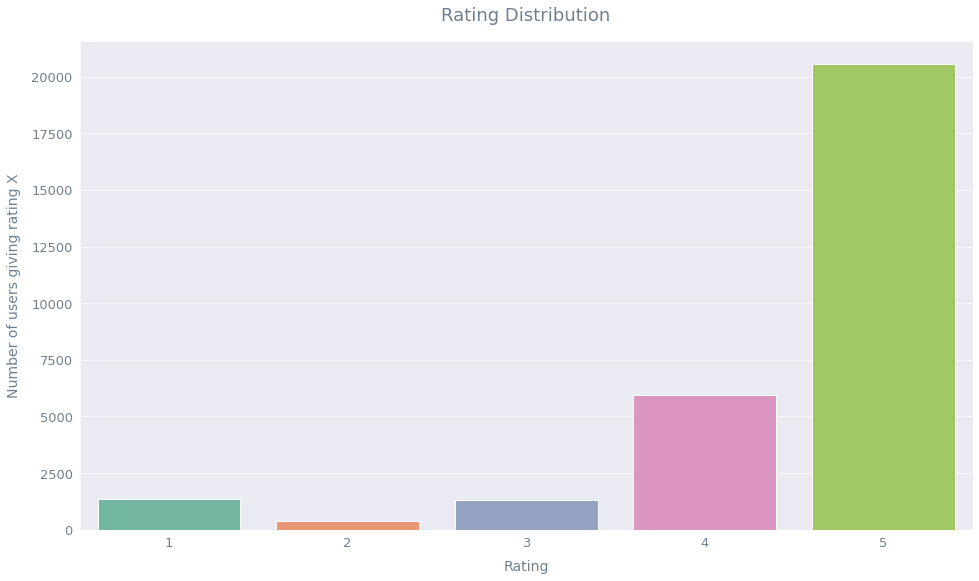

In [46]:
# Create a bar chart of rating distribution
chart = sns.countplot(data=products, x='reviews_rating', palette='Set2');
# Set title, axes labels of the chart
chart.set(title='Rating Distribution', xlabel='Rating', ylabel='Number of users giving rating X');

### 2. User sentiment distribution

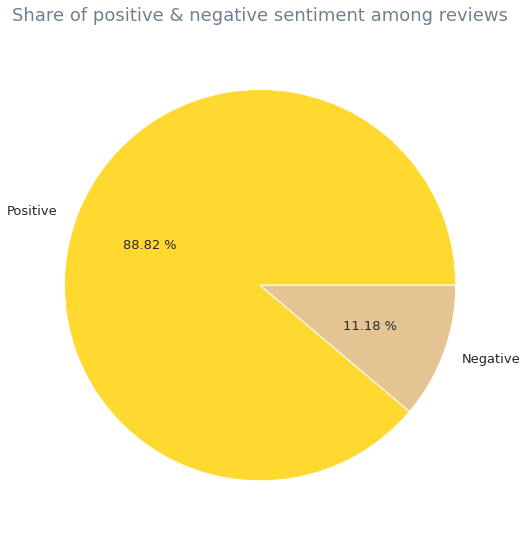

In [47]:
plt.figure(figsize=(16,9))
sentiment_prop = products.user_sentiment.value_counts()
# Create a pie chart of user_sentiment distribution
ax = sentiment_prop.plot.pie(autopct='%.2f %%', colors=sns.color_palette('Set2')[5:], labels=sentiment_prop.index);
# Set title, axes labels of the chart
ax.set_title('Share of positive & negative sentiment among reviews');
ax.set_ylabel('');

### 3. Most reviewed brands

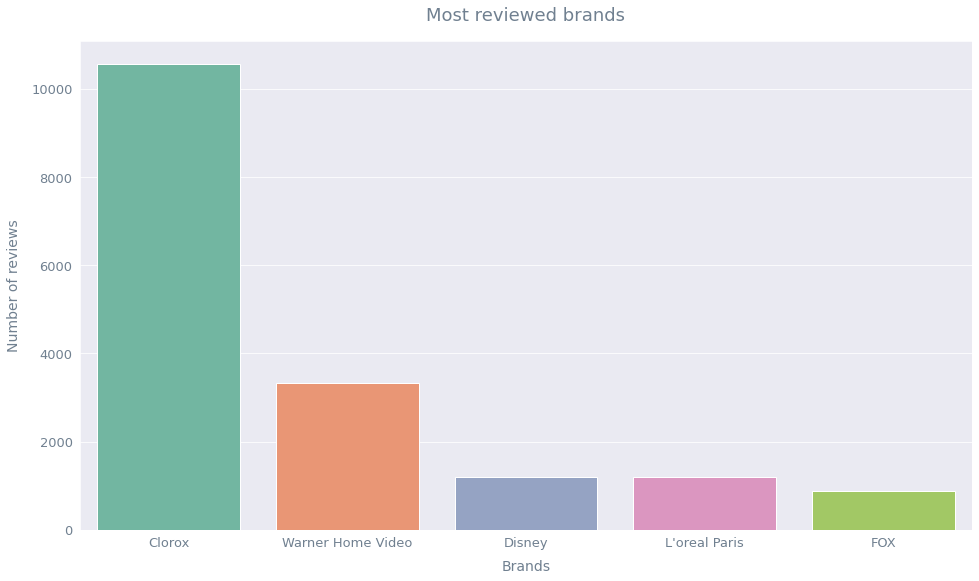

In [48]:
# get top 5 brands with most number of reviews
top_5_brands = products.brand.value_counts().sort_values(ascending=False)[:5]
# Create a bar chart of distribution of reviews over brands
chart = sns.barplot(x=list(top_5_brands.index), y=top_5_brands.values, palette='Set2');
# Set title, axes labels of the chart
chart.set(title='Most reviewed brands', xlabel='Brands', ylabel='Number of reviews');

### 4. Review count distribution among top categories

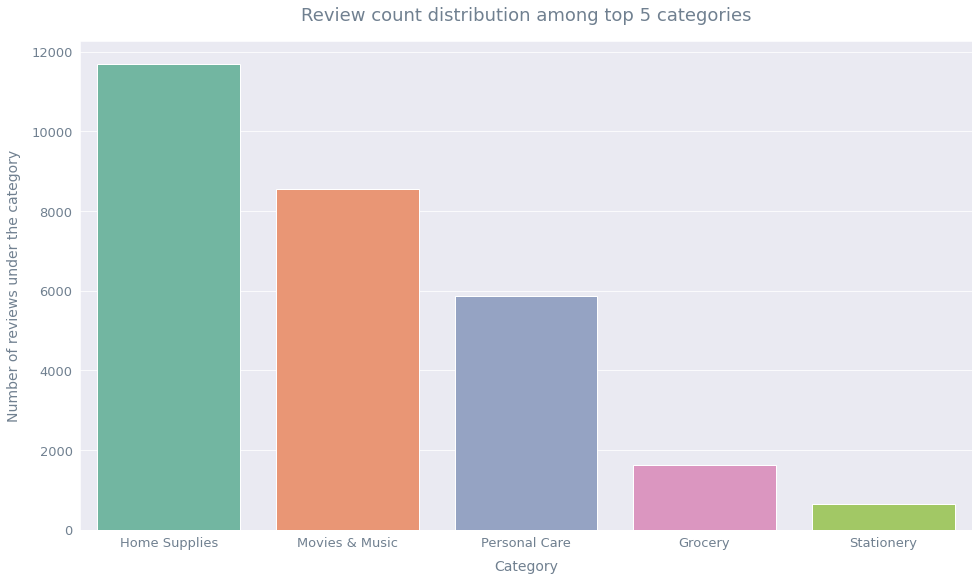

In [49]:
# get top 5 category with most number of reviews
top_5_category = products['broad_category'].value_counts().sort_values(ascending=False)[:5]
# Plot a barchart  showing distribution of values across 
chart = sns.barplot(x=top_5_category.index.str.title(), y=top_5_category.values, palette='Set2');
# Set title, axes labels of the chart
chart.set(title='Review count distribution among top 5 categories', xlabel='Category', ylabel='Number of reviews under the category');

# Bivariate Analysis

### 1. Relationship between rating and recommendation (reviews_rating v/s doRecommend)
How many users recommend the product after rating the product as 1, 2, 3, 4, or 5

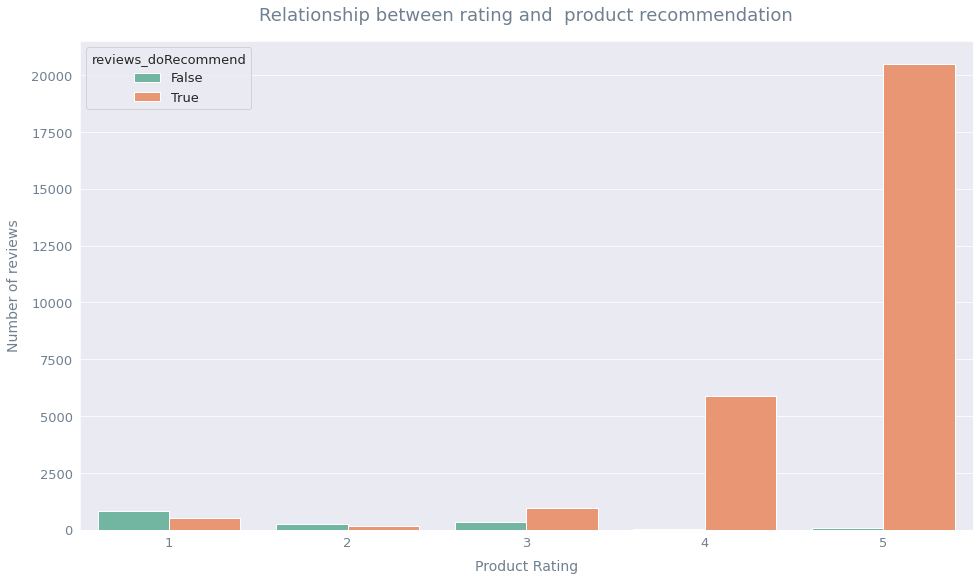

In [50]:
# create a chart showing user recommendation within each category of rating 1 to 5
chart = sns.countplot(data=products, x='reviews_rating',hue='reviews_doRecommend', palette='Set2', animated=True);
# Set title, axes labels of the chart
chart.set(title='Relationship between rating and  product recommendation', xlabel='Product Rating', ylabel='Number of reviews');

### 2. Top reviewed brands across categories
In each of the Top 5 categories, which are the most consumed brands(because each brand has its own niche)

In [51]:
# group by category and brand
brand_cat_dist = products.groupby(by=['broad_category', 'brand'])['id'].count()
# filter out the brands having 0 number of products in each category (not all brands produce product in each category)
brand_cat_dist = brand_cat_dist[brand_cat_dist !=0 ]

brand_cat_dist = brand_cat_dist.reset_index()
# Sort in descending order
brand_cat_dist = brand_cat_dist.sort_values(by=['broad_category', 'id'], ascending=[True, False])
# Just checking how data looks now
brand_cat_dist[brand_cat_dist['broad_category'] == 'home supplies']

,broad_category,brand,id
61,home supplies,Clorox,10563
65,home supplies,Hoover,349
77,home supplies,Windex,348
68,home supplies,Lysol,155
60,home supplies,Bounce,87
66,home supplies,Kraus,37
64,home supplies,Finish,36
62,home supplies,Delta Faucet,24
75,home supplies,The Honest Company,18
69,home supplies,Mrs. Meyer's,15


In [52]:
df = pd.DataFrame()
# for each category
for cat in brand_cat_dist['broad_category'].unique():
    # filter out rows of the category
    temp = brand_cat_dist[brand_cat_dist['broad_category'] == cat]
    # sort new dataframe above by number of product reviews
    temp = temp.sort_values(by='id', ascending=False)[:3]
    # merge the above dataframe with other categories
    df = pd.concat([df, temp], axis=0)
    

In [53]:
df.head(10)

,broad_category,brand,id
0,auto,Meguiars,49
1,auto,Orajel,46
4,furnishing,Feit,8
2,furnishing,Bedtime Originals,6
10,furnishing,Sea Gull Lighting,6
14,furniture,Nojo,8
15,furniture,South Shore,6
12,furniture,INC International Concepts,1
18,gardening,D-Con,7
39,grocery,Lundberg,414


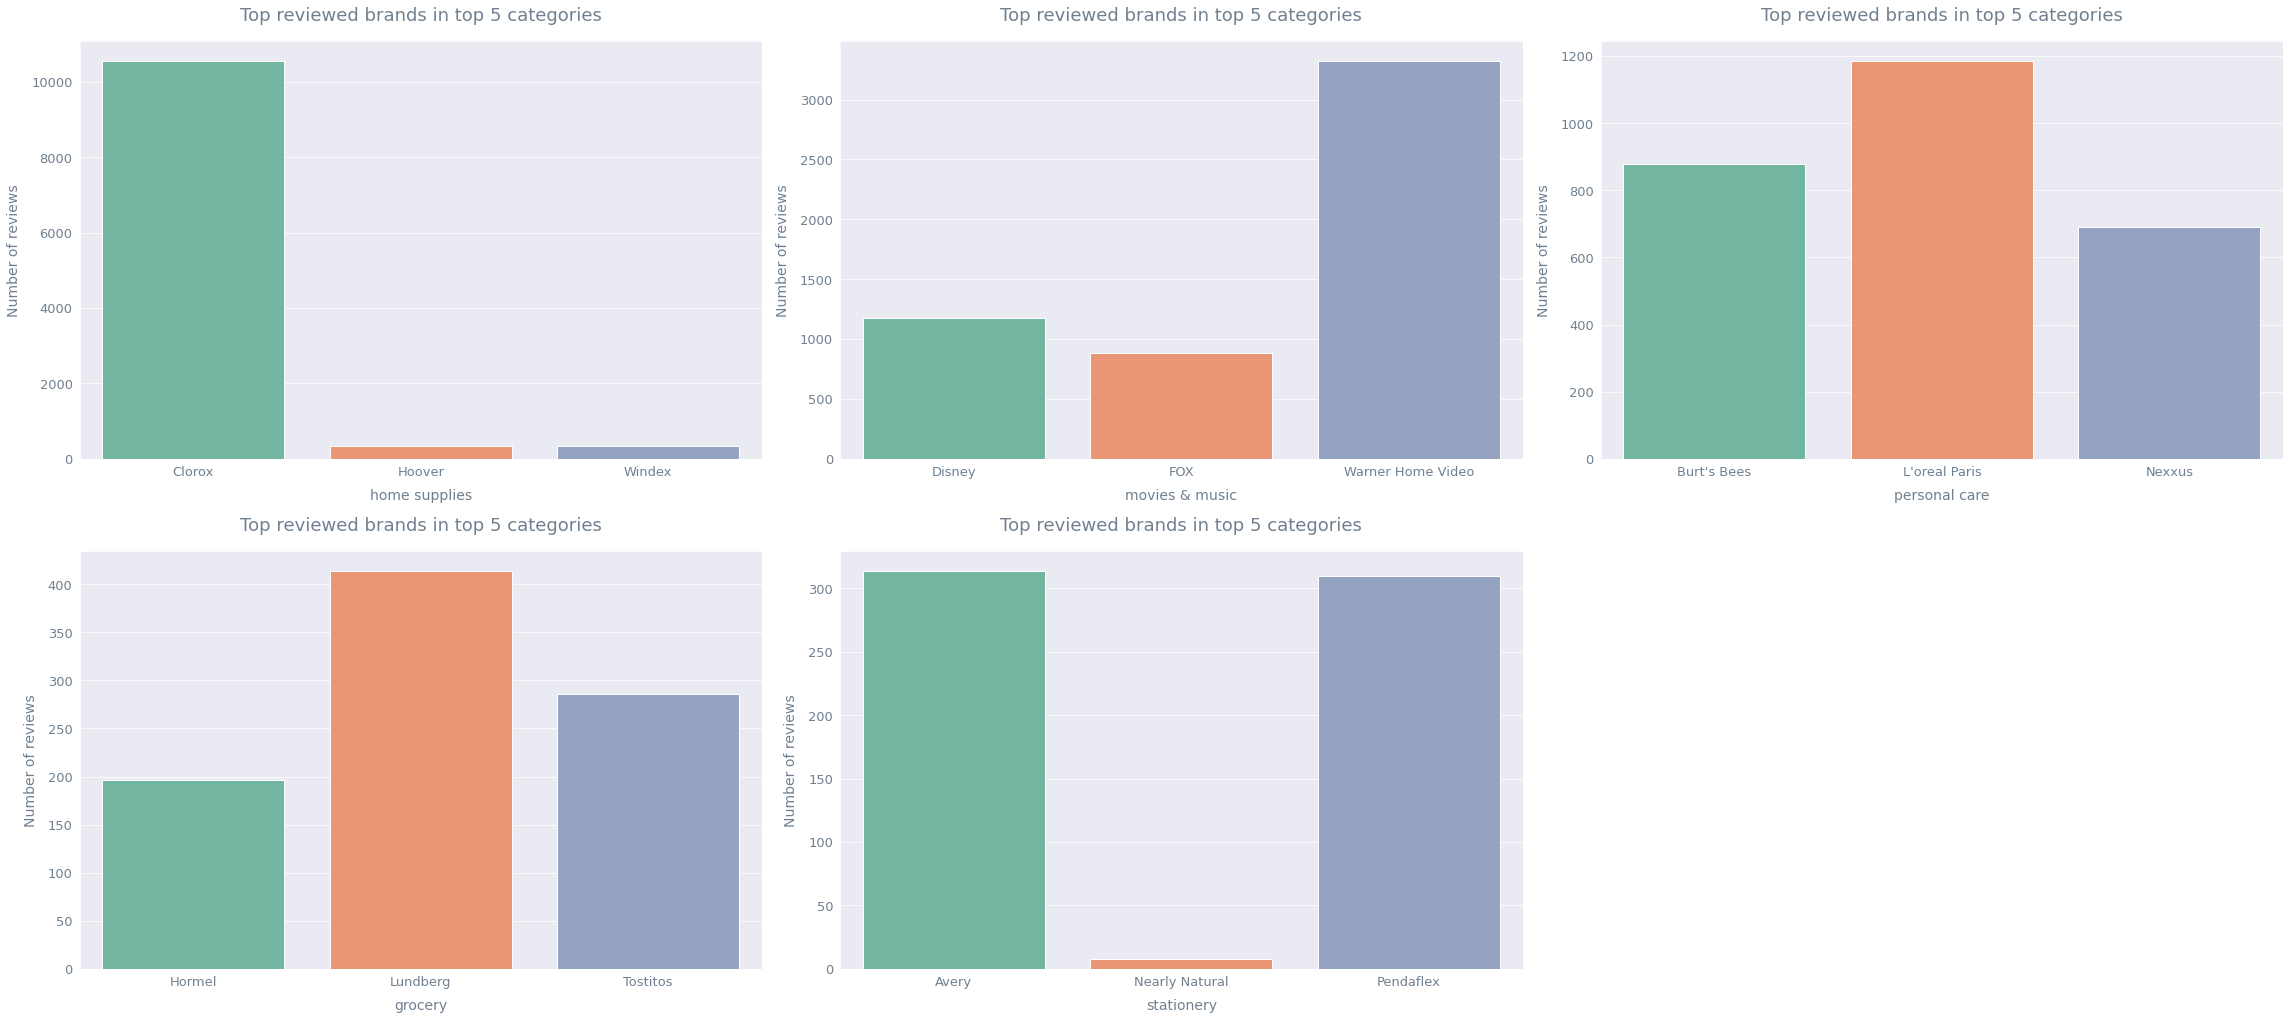

In [54]:
# set figure size
plt.figure(figsize=(32,35))

for idx, name in enumerate(top_5_category.index):
    # create a subplot
    plt.subplot(5,3,idx+1)
    # filter out the data for specific category
    temp = df[df.broad_category == name]
    # reset categorical dtype
    temp.loc[:,'brand'] = temp.brand.cat.remove_unused_categories()
    # Create a barchart for top 3 brands in each category
    chart = sns.barplot(data=temp.reset_index(), x='brand', y='id', palette='Set2');
    # Set title, axes labels of the chart
    chart.set(title='Top reviewed brands in top 5 categories', xlabel=name, ylabel='Number of reviews');
    
plt.tight_layout()

### 3. Trend of ratings over time
How the number of users giving rating 1, or 2, or 3, etc have changed over time. Has it grown for a particular rating or been constant?

In [55]:
def frame_trend(df, rating):
    '''
    Function to create dataset fit for plot showing rating trend over time in quarterly fashion
    '''
    # filter out specific rating from dataset
    df = df[df.rating == rating]
    
    # resample the quarterly results
    df = df.set_index('date').resample('3M')['rating'].count()
    df = df.reset_index()
    
    # take out only date part from date column
    df.date = df.date.dt.date
    return df

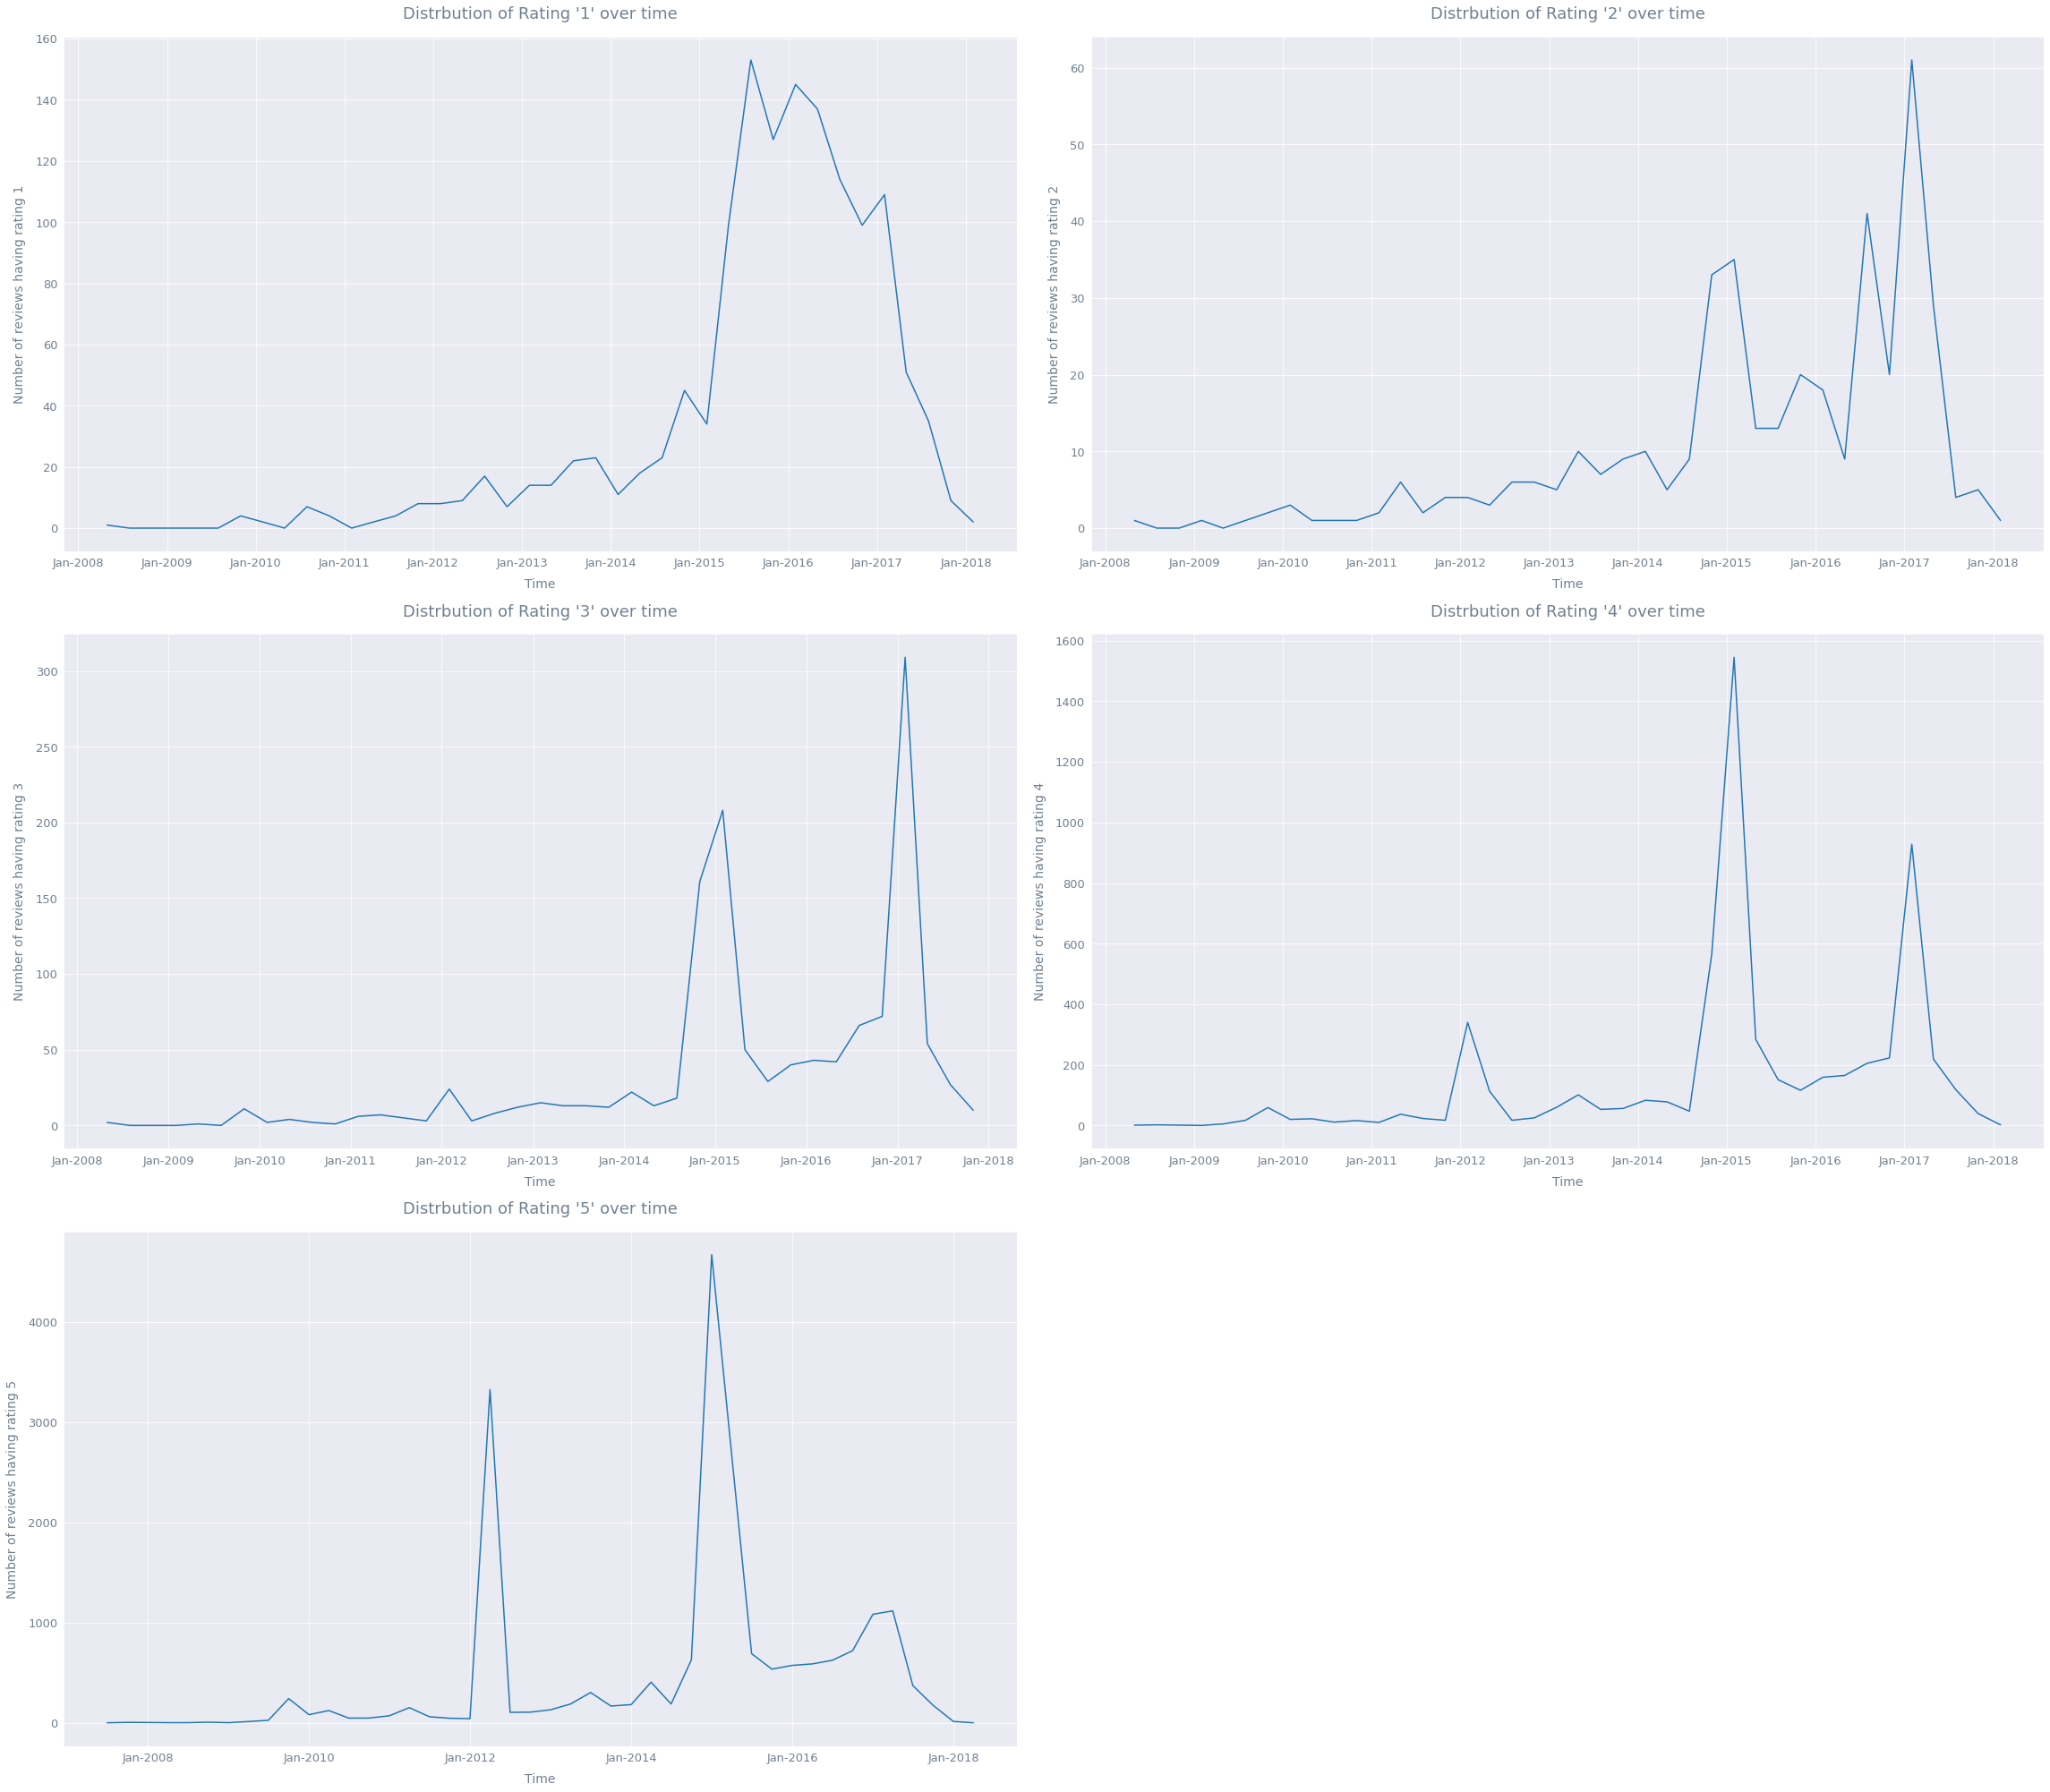

In [56]:
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator

# create dataframe for rating trend
rating_trend = pd.DataFrame({
    'date': products.reviews_date,
    'rating': products.reviews_rating
}).sort_values(by='date')

plt.figure(figsize=(32, 28));

for i in range(1, 6):
    # create a subplot
    ax = plt.subplot(3, 2, i)
    
    # create a lien graph showing rating trend over time
    plt.plot(frame_trend(rating_trend, i).date, frame_trend(rating_trend, i).rating);
    
    # Set title, axes labels of the chart
    ax.set(title=f"Distrbution of Rating '{i}' over time", xlabel='Time', ylabel=f'Number of reviews having rating {i}')
    
    # Keep only month and year of the date in axis tick labels
    ax.xaxis.set_major_formatter(DateFormatter("%b-%Y"))
    ax.xaxis.set_minor_formatter(DateFormatter("%b-%Y"))
plt.tight_layout()

<br/>

# Text Analysis

Lets analyze the reviews_text and title.

We will check the reviews for keywords of indicators of customer satisfaction like awesome, good, great, etc.

In [57]:
products.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,broad_category
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45+00:00,False,True,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive,others
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,True,True,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive,grocery


But before analysing the text, we have to clean the text a little because a lot of words are there which are very rarely occuring in reviews so they won't contribute to our understanding of the nature of the reviews people tend to write

### Preprocessing

In [58]:
def basic_preprocess(text: str):
    '''
    Function which preprocessed any given string 
    Includes lowercasing, removal of punctuation marks and stopwords, removal of numbers
    '''
    # convert to lower case
    sent = text.lower()
    # tokenize the sentences
    sent = TweetTokenizer().tokenize(sent)
    # remove punctuation
    sent = [word for word in sent if word not in punctuation]
    # remove stop words
    sent = [word for word in sent if word not in stop_words_collection]
    # remove numbers
    sent = [word for word in sent if not word.isnumeric()]
    # remove common typos
    sent = [word for word in sent if word not in ['...', '..', "i'm"]]
    # join the list back to sentence
    sent = ' '.join(sent)
    
    return sent

In [59]:
def remove_common_words(texts, limit=50):
    '''
    Function which, given a list of strings, removes top `limit` words which are common across all set of strings
    '''
    # create a single text string from a list of strings
    script = ' '.join(texts)
    # count occurences of words
    counter = Counter(script.split())
    # Find top n most frequent words, n=limit
    frequent_words = [key for key, val in counter.most_common(limit)]
    #Create a new list of strings which dont contain the frequent word
    documents = []
    for sent in texts:
        # remove frequent words from document, if present
        text = [word for word in sent.split() if word not in frequent_words]
        documents.append(' '.join(text))
    # return new list
    return documents

In [60]:
def remove_rare_words(texts, limit=10):
    '''
    Function which, given a list of strings, removes `limit` words which are most rare across all set of strings
    '''
    # create a single text string from a list of strings
    script = ' '.join(texts)
    # count occurences of words
    counter = Counter(script.split())
    # Find least occuring n words, n=limit
    rare_words = [key for key, val in counter.most_common()[:-limit:-1]]
    #Create a new list of strings which dont contain the rare words
    documents = []
    for sent in texts:
        # remove rare words from document, if present
        text = [word for word in sent.split() if word not in rare_words]
        documents.append(' '.join(text))
    # return new list
    return documents

In [61]:
checker = SpellChecker()

def spell_check(text: str):
    '''
    Function to correct spelling mistakes in a given text
    '''
    sentence = []
    for word in text.split():
        # create a list of words. if unknown, do spellcheck, else append as it is
        if word in checker.unknown(word):
            sentence.append(checker.correction(word))
        else:
            sentence.append(word)
    
    return ' '.join(sentence)

In [62]:
lemmatizer = WordNetLemmatizer()

def morphological_form(text):
    '''
    Lemmatize each word to its base form
    '''
    # Lemmatize each word assuming a default Noun form
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

In [63]:
# merge the title and text of a product review
products.reviews_text = products.reviews_title + ' ' + products.reviews_text

reviews_list = products.reviews_text.to_list()
# create a list of stop words in english
stop_words_collection = stopwords.words('english')

In [64]:
reviews = []
for item in reviews_list:
    # Apply basic preprocessing of review
    review = basic_preprocess(item)
    reviews.append(review)
# Remove rare words only specific to 3-4 reviews
reviews = remove_rare_words(reviews)

In [65]:
# Remove most common words across all reviews
# reviews = remove_common_words(reviews, 10)

In [66]:
reviews_list = reviews.copy()
reviews = []
for review in reviews_list:
    # Spell Check
    review = spell_check(review)
    # Lemmatize the words in review
    sentence = morphological_form(review)
    reviews.append(review)

In [67]:
# Set reviews_text column with preprocessed reviews 
products['reviews_text'] = reviews
# Create a copy for future use
products_preprocessed = products.copy()

In [68]:
# Drop columns which will not be required for sentiment analysis
products = products.drop(columns=['id', 'brand', 'categories','manufacturer','name','reviews_didPurchase','reviews_date', 'reviews_title', 'reviews_username', 'broad_category'])
products.head()

,reviews_doRecommend,reviews_rating,reviews_text,user_sentiment
0,True,5,awesome love album good hip hop side current p...,Positive
1,True,5,good good flavor review collected part promotion,Positive
2,True,5,good good flavor,Positive
3,False,1,disappointed read reviews looking buying one c...,Negative
4,False,1,irritation husband bought gel us gel caused ir...,Negative


Now that our text is cleansed, we can check the prominently occuring words in the case of positive and negative sentiment

### Word cloud of positive and negative sentiments

In [69]:
def create_wordcloud(df, column, vals, titles, colors):
    '''
    Function to create a word cloud of the textual feature 'column' in a dataframe 'df'
    '''
    plt.figure(figsize=(32, 10))
    
    for i in range(2):
        # create a temporary with filter applied using 'vals'
        filtered = df[df[column] == vals[i]]
        # generate wordcloud
        cloud_gen = WordCloud(width=1280, height=720,background_color='white', random_state=34, colormap=colors[i], stopwords=STOPWORDS, max_words=100).generate(' '.join(filtered['reviews_text'].to_list()))
        # create a subplot
        plt.subplot(1, 2, i+1);
        
        # change axes properties for display purpose
        plt.axis('off');
        plt.title(titles[i], fontsize=32);
        plt.imshow(cloud_gen);
        plt.axis('off');
        
    plt.tight_layout()

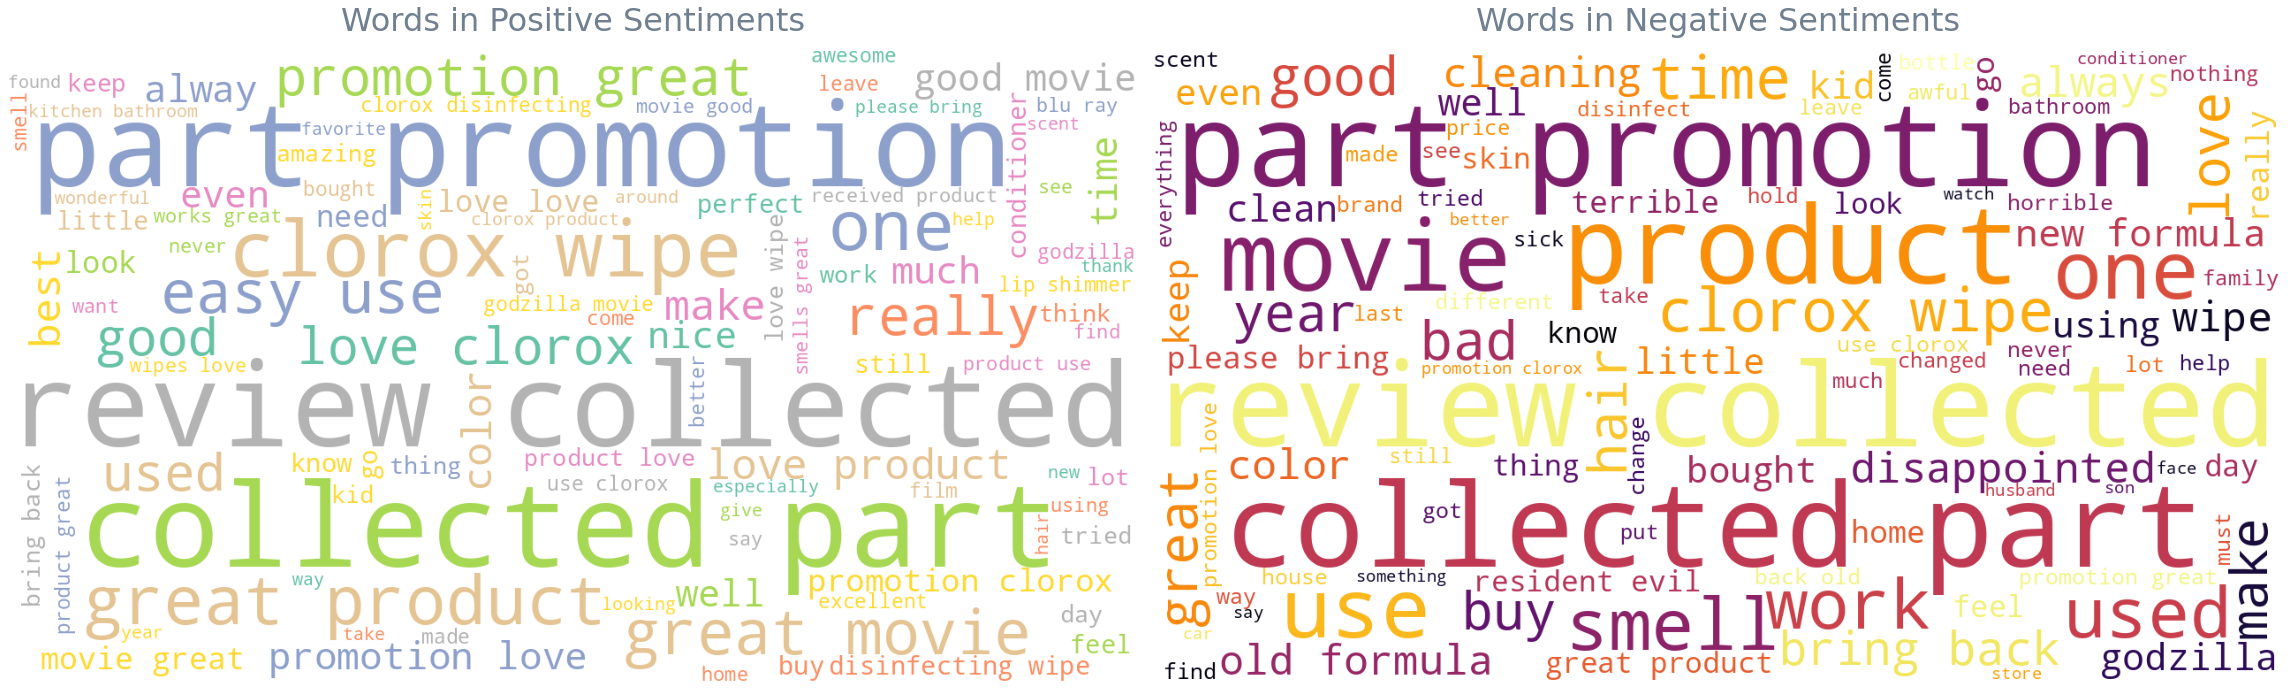

In [70]:
# create wordcloud for user_sentiment 
create_wordcloud(products, 'user_sentiment', ['Positive', 'Negative'], ['Words in Positive Sentiments','Words in Negative Sentiments'], ['Set2','inferno'])

<br/>

*We can also check the word pattern in case of the products that were recommended vs those which were not.*

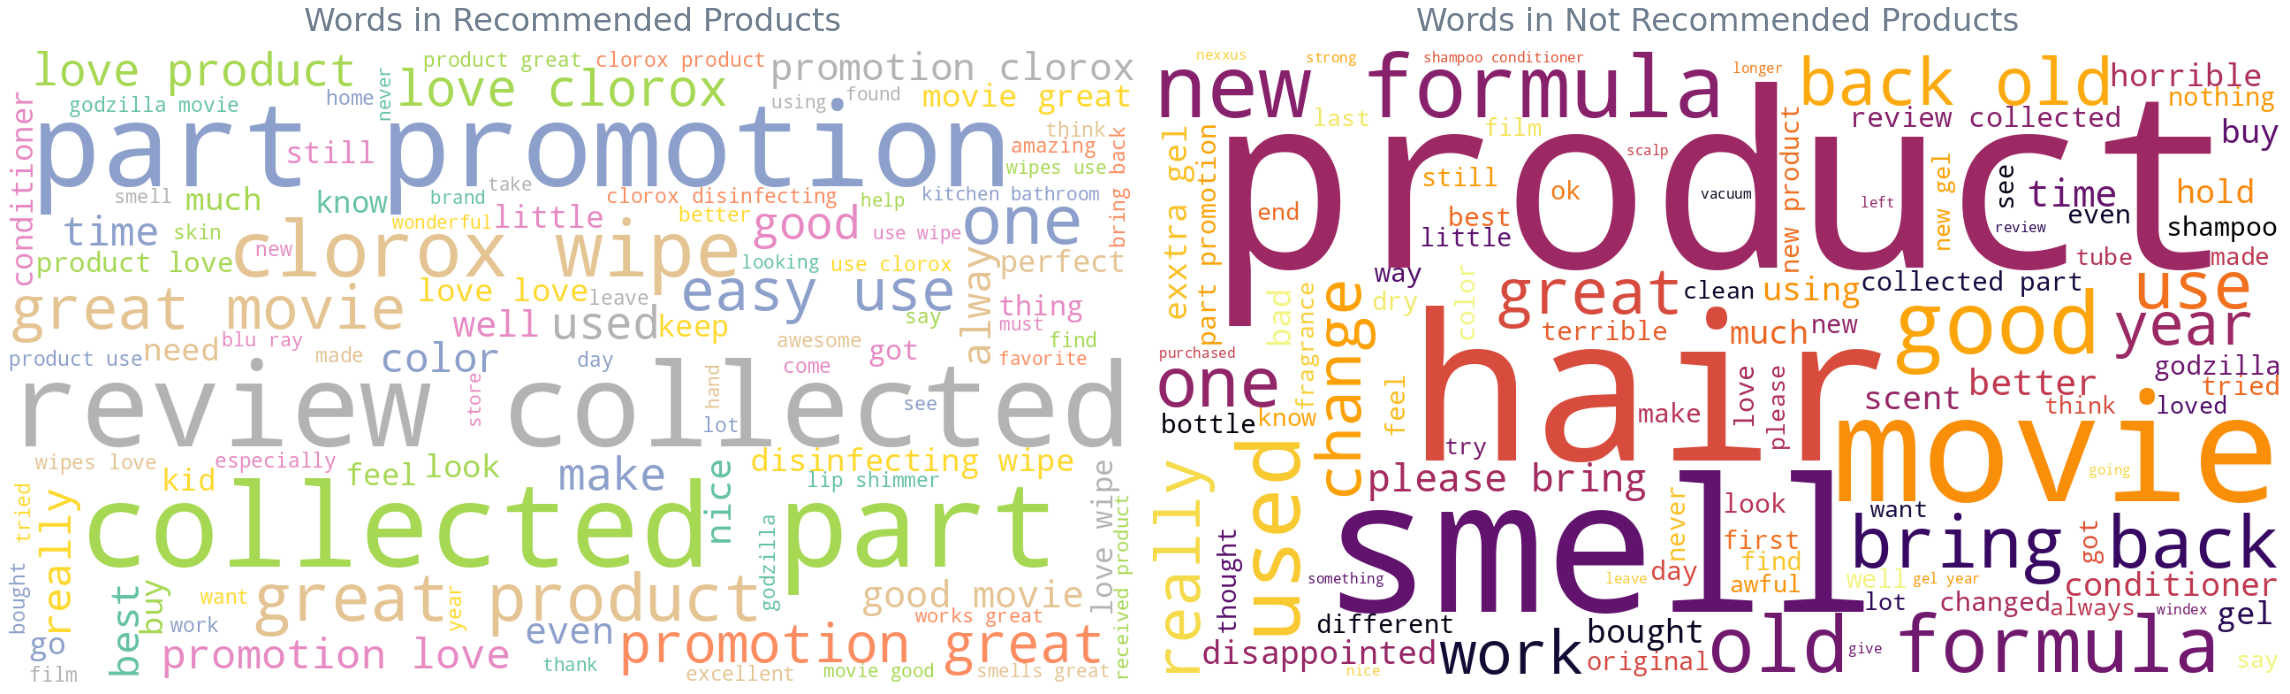

In [71]:
# create wordcloud for user recommendation 
create_wordcloud(products, 'reviews_doRecommend', [True, False], ['Words in Recommended Products','Words in Not Recommended Products'], ['Set2','inferno'])

*Now that we have analyzed our words patterns we can move ahead to building a model for sentiment analysis*

# Building a model

## Data Prep

In [72]:
products.head()

,reviews_doRecommend,reviews_rating,reviews_text,user_sentiment
0,True,5,awesome love album good hip hop side current p...,Positive
1,True,5,good good flavor review collected part promotion,Positive
2,True,5,good good flavor,Positive
3,False,1,disappointed read reviews looking buying one c...,Negative
4,False,1,irritation husband bought gel us gel caused ir...,Negative


**We need to convert the data into numeric format for model**

In [73]:
# convert reviews_doRecommend and user_sentiment to numeric values for modelling
products.user_sentiment = products.user_sentiment.map({'Positive': 1, 'Negative': 0});
# Drop columns reviews_doRecommend and reviews_rating
products.drop(columns=['reviews_doRecommend', 'reviews_rating'], inplace=True)

In [74]:
products.head()

,reviews_text,user_sentiment
0,awesome love album good hip hop side current p...,1
1,good good flavor review collected part promotion,1
2,good good flavor,1
3,disappointed read reviews looking buying one c...,0
4,irritation husband bought gel us gel caused ir...,0


In [75]:
# create independent and dependent variables
y = products.pop('user_sentiment')
X = products
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 42)

In [76]:
# checking percentage of values in train and test set
X_train.shape[0]/X.shape[0], X_test.shape[0]/X.shape[0], y_train.shape[0]/y.shape[0], y_test.shape[0]/y.shape[0]

(0.699979700926991, 0.300020299073009, 0.699979700926991, 0.300020299073009)

In [77]:
Counter(y_train).most_common(2)

[(1, 18363), (0, 2327)]

## Feature Extraction

To feed the data to model, we will use a TfIdf Vectorizer since it takes into account the word importance in a document relative to other documents as well.

In [78]:
# Converting the texts to TFIdf vectors
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train.reviews_text)

## Handling class imbalance

From the analysis above, we can see that there are 88% positive sentiment reviews and only 12% negative sentiment. So clearly there is a class imbalance. 
We can treat the class imbalance with several techniques like:

 - random undersampling of major class
 - random oversampling of minority class
 - SMOTE technique to generate artificial data points
 - undersampling using tomek links
 
1. We will first use the tomek links algorithm to remove the data points from majority class that are close to boundary separating the two classes. Not much difference is expected, but this step will give a clear boundary which can help in the second step.
2. The second step is to oversampling the data. Now the oversampling can be done using SMOTE technique which generate artificial data points for minority class.

In [79]:
# removing the majority class points close to the boundary separating the two classes
tmlk = TomekLinks()
X_train_res, y_train_res = tmlk.fit_resample(X_train, y_train)

In [80]:
# checking the shape of resampled data
Counter(y_train_res).most_common(2)

[(1, 18113), (0, 2327)]

As expected, not much difference but around 200 points from majority class were removed

In [81]:
# Generating artificial data points using SMOTE technique
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train_res, y_train_res)

In [82]:
# checking the shape of final dataset
Counter(y_train_sm).most_common(2)

[(1, 18113), (0, 18113)]

Now we can try building the models

In [83]:

def metrics(y_true, y_pred, y_pred_prob):
    '''
    Function to compute various model evaluation metrics given true and predicted values(actual and probability)
    '''
    cm = confusion_matrix(y_true, y_pred)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    # Acccuracy means out of total classifications, how many were correctly classified
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    # Precision: means out of all classified as positive how many are actually positive
    precision = TP/(TP+FP)
    # recall means out of all actually positive how many were correctly classified as positive
    recall = TP/(TP+FN)
    # specificity means out of all actual negatives, how many were correctly classified as negative
    specificity = TN/(TN+FP)
    # sensitivity means out of all actual positives, how many were correctly classified as positive
    # sensitivity = recall
    sensitivity = TP/(TP+FN)
    # TPR means out of all actual positives, how many were correctly classified as positive
    # TPR = sensivity = recall
    TPR = TP/(TP+FN)
    # FPR means out of all actual negatives, how many were incorrectly classified as positive
    # FPR = 1- specificity
    FPR = FP/(TN+FP)
    
    roc_scoring = roc_auc_score(y_true=y_true, y_score=y_pred_prob[:, 1])
    metrics_table = pd.DataFrame({'metric': ['accuracy', 'precision', 'recall', 'specificity', 'sensitivity', 'TPR', 'FPR', 'ROC AUC Score'], 
                         'value': [accuracy, precision, recall, specificity, sensitivity, TPR, FPR, roc_scoring]
                        })
    metrics_table['value'] = metrics_table['value'].round(3)
    return metrics_table


def draw_roc_curve(y_true, y_pred, y_pred_prob):
    '''
    Function to plot a chart displaying the ROC Curve for a model with given true and predicted values
    '''
    # Calculate TPR, FPR of the model
    fpr, tpr, threshold = roc_curve(y_true=y_true, y_score=y_pred_prob[:, 1])
    # calculate AUC score
    score = roc_auc_score(y_true=y_test, y_score=y_pred_prob[:, 1]);
    # Plot the chart
    plt.plot(fpr, tpr, label=f'AUC Score {round(score, 3)}');
    # add legend
    plt.legend();

<br/>

<br/>
We will build 3 models

1. Logistic Regression
2. Random Forest
3. Naive Bayes

### 1. Logistic Regression model

In [84]:
# Create a default LR model with only change in max-iterations to help it converge better
lr = LogisticRegression(max_iter=500) 
lr.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [85]:
# Transform the test data with vectorizer created during transformation of text to TF-IDF vectors
X_test = vectorizer.transform(X_test.reviews_text)

In [86]:
# Calculate predicted class and probability of classification to each class
y_pred_prob = lr.predict_proba(X_test)
y_pred = lr.predict(X_test)

In [87]:
# Calculate model evaluation metrics
metrics(y_true=y_test, y_pred=y_pred, y_pred_prob = y_pred_prob)

,metric,value
0,accuracy,0.908
1,precision,0.911
2,recall,0.995
3,specificity,0.212
4,sensitivity,0.995
5,TPR,0.995
6,FPR,0.788
7,ROC AUC Score,0.928


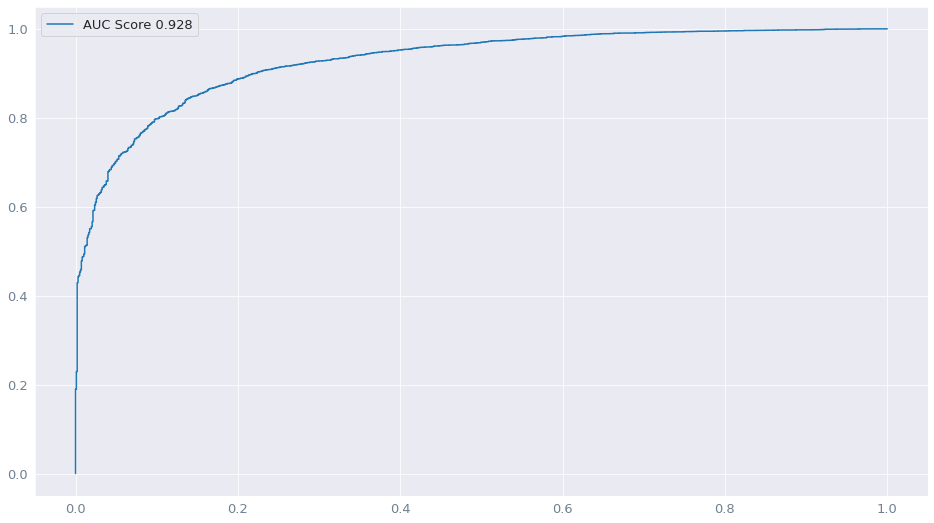

In [88]:
# Draw ROC Curve
draw_roc_curve(y_test, y_pred, y_pred_prob)

*The default model is giving an AUC ROC Score of 0.928. Let's check if it can be further improed with Grid search*

In [89]:
REGULARIZATION_PARAMS = [0.01, 0.03, 0.09, 0.1, 0.3, 0.9, 1, 3, 9, 10]

In [90]:
# Create folds of training data using stratified sampling
folds = StratifiedKFold(shuffle=True, n_splits=5, random_state=42)

# create LR model
lr = LogisticRegression(max_iter=500)

# Setup Grid Search with different parameters
grid_search = GridSearchCV(estimator=lr, param_grid={
    'penalty': ['l2'],
    'C': REGULARIZATION_PARAMS,
    'class_weight': [None, 'balanced']
}, n_jobs=-1, cv=folds, scoring='roc_auc', verbose=True)

In [91]:
# Fit grid search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=500), n_jobs=-1,
             param_grid={'C': [0.01, 0.03, 0.09, 0.1, 0.3, 0.9, 1, 3, 9, 10],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l2']},
             scoring='roc_auc', verbose=True)

In [92]:
# Save best model from grid search into different variable(future use)
best_lr_model = grid_search.best_estimator_

# Calculate predicted class and probability of classification to each class
y_pred = grid_search.best_estimator_.predict(X_test)
y_pred_prob = grid_search.best_estimator_.predict_proba(X_test)

# Calculate model evaluation metrics
metrics(y_true=y_test, y_pred=y_pred, y_pred_prob = y_pred_prob)

,metric,value
0,accuracy,0.918
1,precision,0.926
2,recall,0.987
3,specificity,0.364
4,sensitivity,0.987
5,TPR,0.987
6,FPR,0.636
7,ROC AUC Score,0.931


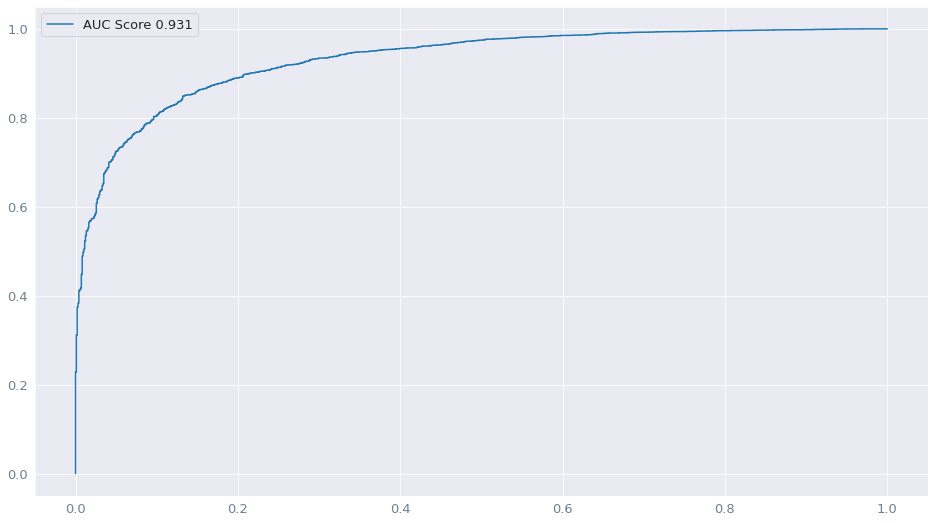

In [93]:
# Draw ROC Curve
draw_roc_curve(y_test, y_pred, y_pred_prob)

**So we got an AUC ROC Score of 0.931 which is better than previous one 0.924**

<br/>

<br/>

### 2. RandomForest Classifier

In [94]:
from sklearn.ensemble import RandomForestClassifier

In [95]:
# create a default Random Forest model
clf = RandomForestClassifier(random_state=42)
# fit over training data
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [96]:
# Calculate predicted class and probability of classification to each class
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)

In [97]:
# Calculate default model evaluation metrics
metrics(y_true=y_test, y_pred=y_pred, y_pred_prob=y_pred_prob)

,metric,value
0,accuracy,0.908
1,precision,0.908
2,recall,0.997
3,specificity,0.188
4,sensitivity,0.997
5,TPR,0.997
6,FPR,0.812
7,ROC AUC Score,0.891


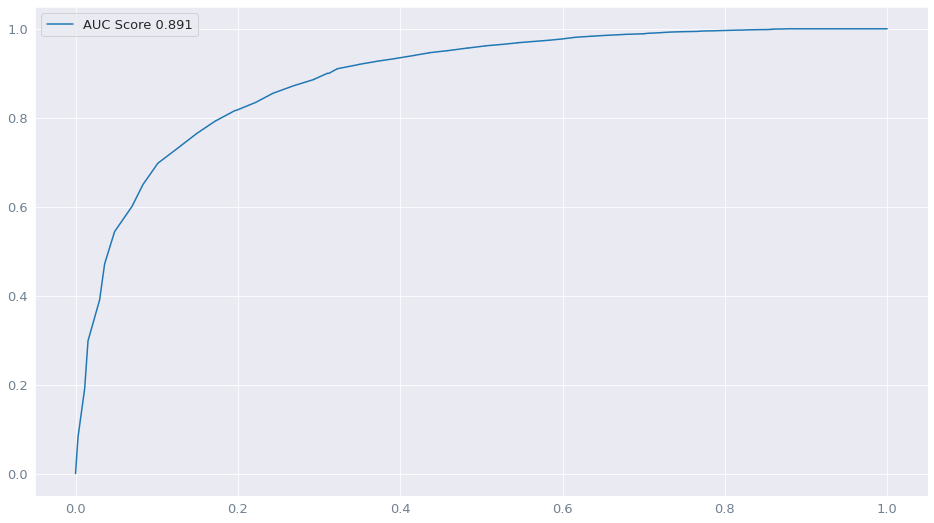

In [98]:
# Draw ROC Curve
draw_roc_curve(y_test, y_pred, y_pred_prob)

So the default param model is having 0.891 AUC ROC Score. So we shall try fitting the model with hyperparam tuning.

In [99]:
# Setup Grid Search with different parameters
grid_search = GridSearchCV(estimator=clf, param_grid={
    'max_depth': range(1, 30, 4),
    'min_samples_leaf': range(2, 10, 2),
    'min_samples_split': range(10, 30, 2),
    'n_jobs': [4],
    'random_state': [42]
}, cv=5, verbose=True, scoring='roc_auc', n_jobs=-1)

# Fit grid search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(1, 30, 4),
                         'min_samples_leaf': range(2, 10, 2),
                         'min_samples_split': range(10, 30, 2), 'n_jobs': [4],
                         'random_state': [42]},
             scoring='roc_auc', verbose=True)

In [100]:
# Save best model from grid search into different variable(future use)
best_rf_model = grid_search.best_estimator_

# Calculate predicted class and probability of classification to each class
y_pred = best_rf_model.predict(X_test)
y_pred_prob = best_rf_model.predict_proba(X_test)

# Calculate best model evaluation metrics
metrics(y_true=y_test, y_pred=y_pred, y_pred_prob=y_pred_prob)

,metric,value
0,accuracy,0.890
1,precision,0.890
2,recall,1.000
3,specificity,0.000
4,sensitivity,1.000
5,TPR,1.000
6,FPR,1.000
7,ROC AUC Score,0.874


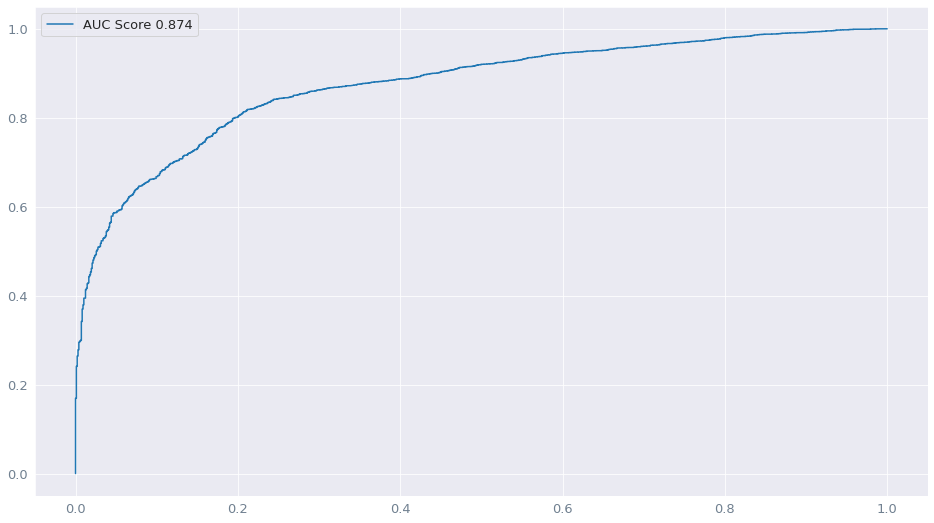

In [101]:
# Draw ROC Curve
draw_roc_curve(y_test, y_pred, y_pred_prob)

<br/>

<br/>

### 3. Naive Bayes Classifier

In [102]:
# Create a Naive Bayes Classifier with default parameters
nb = MultinomialNB()
# Fit over training data
nb.fit(X_train, y_train)

MultinomialNB()

In [103]:
# Calculate predicted class and probability of classification to each class
y_pred= nb.predict(X_test) 
y_pred_prob = nb.predict_proba(X_test)

# Calculate model evaluation metrics
metrics(y_true=y_test, y_pred=y_pred, y_pred_prob = y_pred_prob)

,metric,value
0,accuracy,0.890
1,precision,0.890
2,recall,1.000
3,specificity,0.001
4,sensitivity,1.000
5,TPR,1.000
6,FPR,0.999
7,ROC AUC Score,0.806


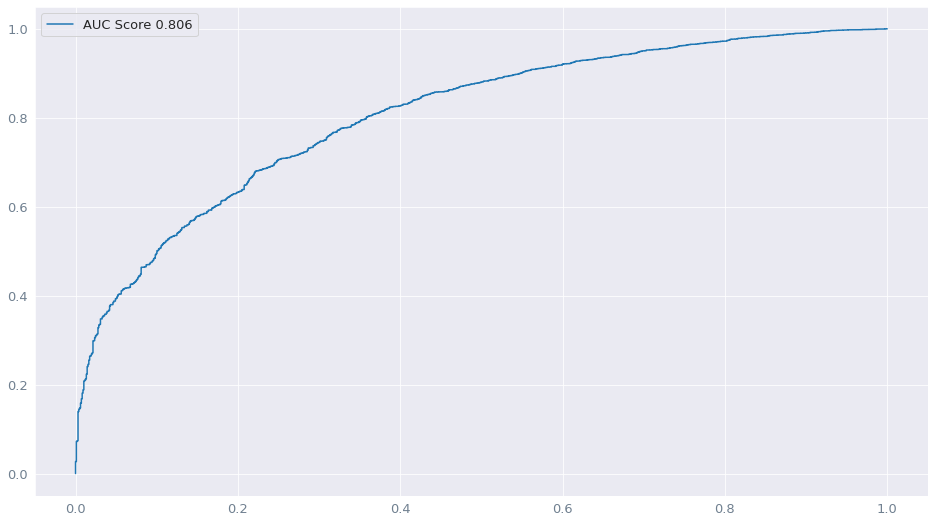

In [104]:
# Draw ROC Curve
draw_roc_curve(y_test, y_pred, y_pred_prob)

In case of Naive Bayes, the model is having AUC ROC Score of 0.806.

<br/>



**Since Linear Regression was the best performing model with ROC_AUC score of 0.931, we shalll finalise it for predictions.**

In [105]:
# Write Best Model to disk
with open('LinearRegressionModel.pkl', 'wb') as file:
    pickle.dump(best_lr_model, file)

# Write Tf_IDF Vectorizer to disk
with open('TFIDFTransformer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

<br/>
<br/>
<hr/>
<br/>
<br/>

# Recommendation Engine

There are two ways in which a recommendation engine can be built
- User-User based collaborative filtering
- Item-item based collaborative filtering

Lets explore User User based collaboarative filtering first

## 1. User Based Collaborative Filtering

### Training or building similarity matrix

In [106]:
# From clean dataset extract required columns
recommendation_df = products_cleaned[['name','reviews_username','reviews_rating']]
recommendation_df

,name,reviews_username,reviews_rating
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5
1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
2,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
3,K-Y Love Sensuality Pleasure Gel,rebecca,1
4,K-Y Love Sensuality Pleasure Gel,walker557,1
...,...,...,...
29995,L'or233al Paris Elvive Extraordinary Clay Reba...,laurasnchz,5
29996,L'or233al Paris Elvive Extraordinary Clay Reba...,scarlepadilla,5
29997,L'or233al Paris Elvive Extraordinary Clay Reba...,liviasuexo,5
29998,L'or233al Paris Elvive Extraordinary Clay Reba...,ktreed95,5


In [107]:
# train test split
train_df, test_df = train_test_split(recommendation_df, test_size=0.3, random_state=42)
# Checking shape of train and test set
train_df.shape, test_df.shape

((20690, 3), (8868, 3))

*After spilling train and test set, we will compute similarity between each of the users*

In [108]:
# prepare user similarity matrix using cosine similarity
train_pivot  = train_df.pivot_table(index='reviews_username',columns='name',values='reviews_rating')
user_similarity = cosine_similarity(train_pivot.fillna(0))

In [109]:
# Display user similarity matrix
user_similarity

array([[1.       , 0.       , 0.       , ..., 0.       , 0.9486833,
        0.       ],
       [0.       , 1.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ],
       [0.9486833, 0.       , 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ]])

Now negative similarity scores actually mean the users are opposite of each other in their likings. So we shall remove those users from our consideration. 

And a simple way to do that will be do make their similarity 0

In [110]:
# Filter out the negative correlation values
user_similarity[user_similarity <0 ]=0

In [111]:
# Convert similarity matrix to a dataframe (locating items is easier in dataframe)
user_similarity = pd.DataFrame(user_similarity, index=train_pivot.index, columns=train_pivot.index)

In [112]:
# Display user similarity matrix
user_similarity

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,1085,10ten,11111111aaaaaaaaaaaaaaaaa,11677j,...,zozo0o,zpalma,zsazsa,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.000000,0.0,0.0,0.0,0.0,0.0,0.948683,0.0,0.0,0.0,...,0.0,0.316228,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0
01impala,0.000000,1.0,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
02dakota,0.000000,1.0,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
02deuce,0.000000,1.0,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
0325home,0.000000,0.0,0.0,0.0,1.0,1.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zxcsdfd,0.000000,0.0,0.0,0.0,1.0,1.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,1.0
zxjki,0.000000,0.0,0.0,0.0,1.0,1.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,1.0
zyiah4,0.000000,0.0,0.0,0.0,1.0,1.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,1.0


Now we need not to recommend the items that have already been purchased by a user while giving recommendations. And we can do this by filtering out the items which are already rated by him/her.

To accomplish this, we will create a mask which is a matrix to make ratings 0 if already rated by the user

In [113]:
# Creating a mask to remove items already rated by the user
train_mask = train_pivot.applymap(lambda x: 0 if x>=1 else 1)

**Now finally we will compute the ratings given by each user to each item he has not rated**

In [114]:
# Create recommendations calculated as weighted sum of ratings given by each user
user_based_recommendation = user_similarity @ train_pivot.fillna(0)

In [115]:
# Apply a mask to remove items already rated by the user
user_based_recommendation = user_based_recommendation * train_mask
user_based_recommendation

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,2.301010,0.0,0.0,0.0,0.0,0.0,0.0,2.335497,0.0,...,0.0,1.988981,0.0,0.0,1.272792,0.0,0.0,7.549010,1.776560,0.243975
01impala,0.0,23.278351,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,4.310056,0.0,0.0,2.236068,0.0,0.0,19.125640,1.872658,3.079043
02dakota,0.0,23.278351,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,4.310056,0.0,0.0,2.236068,0.0,0.0,19.125640,1.872658,3.079043
02deuce,0.0,23.278351,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,4.310056,0.0,0.0,2.236068,0.0,0.0,19.125640,1.872658,3.079043
0325home,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,10.633724,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zxcsdfd,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,10.633724,0.000000,0.000000
zxjki,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,10.633724,0.000000,0.000000
zyiah4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,10.633724,0.000000,0.000000


<br/>

**But notice the ratings computed are not within range of 1-5. So we shall scale them down**

In [116]:
# Create copy of ratings calculated above
scaled_user_based_recommendation  = user_based_recommendation.copy() 
# Create a scaler withing 1-5 range
scaler = MinMaxScaler(feature_range=(0, 5))
# Apply scaling on the calculated ratings
scaled_user_based_recommendation = scaler.fit_transform(scaled_user_based_recommendation)
# Convert the ratings to a dataframe
scaled_user_based_recommendation = pd.DataFrame(scaled_user_based_recommendation, columns=user_based_recommendation.columns, index = user_based_recommendation.index)

Now just to test our User-User Based recommendation system, we can assume a test user.

In [117]:
# Assume a test user
given_user_id = 'zyiah4'

# Get the recommendations for the user(sort ratings in descending order)
scaled_user_based_recommendation.loc[given_user_id, :].sort_values(ascending=False)

name
J.a. Henckels International 4-Pc Everedge Plus Steak Knife Set                    5.0
Pantene Pro-V Expert Collection Age Defy Conditioner                              5.0
Switchmas (dvd)                                                                   5.0
L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz    5.0
Clorox Disinfecting Bathroom Cleaner                                              5.0
                                                                                 ... 
Jergens Extra Moisturizing Liquid Hand Wash, 7.5oz                                0.0
Johnson's Baby Bubble Bath and Wash, 15oz                                         0.0
Jolly Time Select Premium Yellow Pop Corn                                         0.0
Just For Men Touch Of Gray Gray Hair Treatment, Black T-55                        0.0
Yes To Grapefruit Rejuvenating Body Wash                                          0.0
Name: zyiah4, Length: 229, dtype: float64


### Evaluation of User-based collab filtering

The recommendation system is trained, but we shall check the performance by computing RMSE. 
To do that, we must know the target value. Since we only know target value of the users which are already present in the training set as well, we will filter out other users 



In [118]:
# Filter out the users in both training and test set
train_test_common_users = test_df[test_df['reviews_username'].isin(train_df['reviews_username'])]

In [119]:
train_test_common_users

,name,reviews_username,reviews_rating
21056,Tostitos Bite Size Tortilla Chips,rick,5
4830,The Resident Evil Collection 5 Discs (blu-Ray),pupsi,5
21619,Nexxus Exxtra Gel Style Creation Sculptor,thai,1
19194,Clorox Disinfecting Bathroom Cleaner,neurotraveller,5
22704,Clear Scalp & Hair Therapy Total Care Nourishi...,jenn,5
...,...,...,...
21429,Nexxus Exxtra Gel Style Creation Sculptor,leggybrunette38,1
21977,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",daysi,5
25724,Godzilla 3d Includes Digital Copy Ultraviolet ...,ctkc,5
2275,Mike Dave Need Wedding Dates (dvd + Digital),datmanvell,5


Now we will create a similarity matrix which only has the users common to both train and test set

In [120]:
# create a testing matrix for users common in both training and test set
test_pivot  = train_test_common_users.pivot_table(index='reviews_username',columns='name',values='reviews_rating')
# create a mask to keep the users who have already rated the items
test_mask = test_pivot.applymap(lambda x: 1 if x>=0 else 0)

In [121]:
# get list of common user names
common_users = train_test_common_users.reviews_username.unique()
# Filter out the similarity matrix with only common users
user_similarity_test = user_similarity.loc[common_users, common_users]

Now we can go ahead to compute the predictions for rating for each of the users common to train adn test set

In [122]:
# get predictions for common users
predictions = user_similarity_test @ test_pivot.fillna(0)

In [123]:
# Apply a mask to keep items already rated by the user
predictions = predictions * test_mask

In [124]:
# Create copy of ratings calculated above
scaled_predictions  = predictions.copy() 
# predictions more than 0
scaled_predictions = scaled_predictions[scaled_predictions>0]
# Create a scaler withing 1-5 range
scaler = MinMaxScaler(feature_range=(1, 5))
# Apply scaling on the calculated ratings
scaled_predictions = scaler.fit_transform(scaled_predictions)

With predictions ready,we can compute the RMSE to find the performance of the model

In [125]:
# calculate total error between predicted and actual ratings
total= ((scaled_predictions - test_pivot.fillna(0))**2).sum().sum()
# calculate non nan items
total_non_nan = np.count_nonzero(~np.isnan(scaled_predictions))

# Calculate RMSE 
n = scaled_predictions.shape[0] * scaled_predictions.shape[1]
rmse = (total / total_non_nan)**0.5

In [126]:
rmse

2.0951381371549154

## 2. Item based collaborative filtering
Similar to user based filtering, we shall compute the simialrity scores, but this time among each of the items rather than users.

### Training or building similarity matrix

In [127]:
# Create a item-user matrix from user-item matrix
train_pivot = train_pivot.T
train_pivot

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,1085,10ten,11111111aaaaaaaaaaaaaaaaa,11677j,...,zozo0o,zpalma,zsazsa,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wedding Wishes Wedding Guest Book,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weleda Everon Lip Balm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
# prepare item similarity matrix using cosine similarity
item_similarity = cosine_similarity(train_pivot.fillna(0))

Similar to user based filtering, we shall rule our items with negative correlation

In [129]:
# Filter out the negative correlation values
item_similarity[item_similarity < 0] = 0
# Convert similarity matrix to a dataframe (locating items is easier in dataframe)
item_similarity = pd.DataFrame(item_similarity, columns=train_pivot.index, index=train_pivot.index)

In [130]:
item_similarity.head(2)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we need not to recommend the items that have already been purchased by a user while giving recommendations. We will create a mask which is a matrix to make ratings 0 if already rated by the user

In [131]:
# Creating a mask to remove items already rated by the user
train_mask = train_pivot.applymap(lambda x: 0 if x>=1 else 1)

**Finally we calculate the ratings for each item that will be given by each user, based on the ratings given by similar items**

In [132]:
# Create recommendations calculated as weighted sum of ratings given by each user
item_based_recommendation = (item_similarity @ train_pivot.fillna(0)).T
item_based_recommendation.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.015562,0.0,0.0,0.0,0.0,0.0,0.0,0.065125,0.0,...,0.0,0.08088,0.0,0.0,0.046363,0.0,0.0,0.035259,0.016049,0.002230
01impala,0.0,0.055401,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.06717,0.0,0.0,0.035651,0.0,0.0,0.037377,0.007405,0.015231
02dakota,0.0,0.092335,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.11195,0.0,0.0,0.059419,0.0,0.0,0.062295,0.012341,0.025385
02deuce,0.0,0.073868,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.08956,0.0,0.0,0.047535,0.0,0.0,0.049836,0.009873,0.020308
0325home,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.020223,0.000000,0.000000


In [133]:
# Apply a mask to remove items already rated by the user
item_based_recommendation *= train_mask.T

In [134]:
item_based_recommendation.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.015562,0.0,0.0,0.0,0.0,0.0,0.0,0.065125,0.0,...,0.0,0.08088,0.0,0.0,0.046363,0.0,0.0,0.035259,0.016049,0.002230
01impala,0.0,0.055401,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.06717,0.0,0.0,0.035651,0.0,0.0,0.037377,0.007405,0.015231
02dakota,0.0,0.092335,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.11195,0.0,0.0,0.059419,0.0,0.0,0.062295,0.012341,0.025385
02deuce,0.0,0.073868,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.08956,0.0,0.0,0.047535,0.0,0.0,0.049836,0.009873,0.020308
0325home,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.020223,0.000000,0.000000


<br/>
As in user based filtering, although we do have a predicted ratings now, but they are not scaled. 
so we will use MinMaxScaler to scale them downin range of 1-5.

In [135]:
# Create copy of ratings calculated above
scaled_item_based_recommendation  = item_based_recommendation.copy() 
# Create a scaler withing 1-5 range
scaler = MinMaxScaler(feature_range=(0, 5))
# Apply scaling on the calculated ratings
scaled_item_based_recommendation = scaler.fit_transform(scaled_item_based_recommendation)
# Convert the ratings to a dataframe
scaled_item_based_recommendation = pd.DataFrame(scaled_item_based_recommendation, columns=item_based_recommendation.columns, index = item_based_recommendation.index)

In [136]:
scaled_item_based_recommendation.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.210325,0.0,0.0,0.0,0.0,0.0,0.0,1.200471,0.0,...,0.0,1.165246,0.0,0.0,0.644473,0.0,0.0,0.385721,0.486672,0.162356
01impala,0.0,0.748754,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.967717,0.0,0.0,0.495578,0.0,0.0,0.408892,0.224541,1.108706
02dakota,0.0,1.247924,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,1.612862,0.0,0.0,0.825963,0.0,0.0,0.681487,0.374235,1.847843
02deuce,0.0,0.998339,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,1.290290,0.0,0.0,0.660770,0.0,0.0,0.545190,0.299388,1.478275
0325home,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.221238,0.000000,0.000000


In [137]:
# Assume a test user
given_user_id = 'zyiah4'
# Get the recommendations for the user(sort ratings in descending order)
scaled_item_based_recommendation.loc[given_user_id, :].sort_values(ascending=False)

name
Pantene Pro-V Expert Collection Age Defy Conditioner                        5.000000
Switchmas (dvd)                                                             5.000000
Clorox Disinfecting Bathroom Cleaner                                        4.008692
Physicians Formula Powder Palette Mineral Glow Pearls, Translucent Pearl    3.637398
Aussie Aussome Volume Shampoo, 13.5 Oz                                      2.285047
                                                                              ...   
Jergens Extra Moisturizing Liquid Hand Wash, 7.5oz                          0.000000
Johnson's Baby Bubble Bath and Wash, 15oz                                   0.000000
Jolly Time Select Premium Yellow Pop Corn                                   0.000000
Just For Men Touch Of Gray Gray Hair Treatment, Black T-55                  0.000000
Yes To Grapefruit Rejuvenating Body Wash                                    0.000000
Name: zyiah4, Length: 229, dtype: float64

### Evaluation of item based collab filtering

The recommendation system is trained, but we shall check the performance by computing RMSE. 
To do that, we must know the target value. Since we only know target value of the users which are already present in the training set as well, we will filter out other users 



In [138]:
# Filter out the users in both training and test set
train_test_common_items = test_df[test_df['name'].isin(train_df['name'])]
train_test_common_items

,name,reviews_username,reviews_rating
3756,Ragu Roasted Garlic Parmesan Pasta Sauce,wonderwoman,2
21056,Tostitos Bite Size Tortilla Chips,rick,5
4830,The Resident Evil Collection 5 Discs (blu-Ray),pupsi,5
7523,Clorox Disinfecting Wipes Value Pack Scented 1...,pperrea211,4
12919,Clorox Disinfecting Wipes Value Pack Scented 1...,tina66,5
...,...,...,...
4795,The Resident Evil Collection 5 Discs (blu-Ray),gamerx23,5
18784,Clorox Disinfecting Bathroom Cleaner,rachell,4
23836,Godzilla 3d Includes Digital Copy Ultraviolet ...,therazorsnake,4
24680,Godzilla 3d Includes Digital Copy Ultraviolet ...,buckeye,5


In [139]:
# create a testing matrix for users common in both training and test set
test_pivot = train_test_common_items.pivot_table(index='name', columns='reviews_username', values='reviews_rating')
test_pivot.head()

reviews_username,00dog3,08dallas,09mommy11,1.11E+24,1143mom,1234567,1234asdf,12cass12,13ram,143st,...,zombiedad80,zombiekiller14,zone,zoney86,zookeeper,zoso60,zsarah,zt313,zubb,zulaa118
name,,,,,,,,,,,,,,,,,,,,,
100:Complete First Season (blu-Ray),NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Africa's Best No-Lye Dual Conditioning Relaxer System Super,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"All,bran Complete Wheat Flakes, 18 Oz.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we will create a similarity matrix which only has the users common to both train and test set

In [140]:
# get list of common user names
common_items = list(train_test_common_items.name.unique())

In [141]:
# Filter out the similarity matrix with only common users
item_similarity_test = item_similarity.loc[common_items, common_items]

We can go ahead to compute the predicted ratings for each user common to both train and test set

In [142]:
predictions = item_similarity_test @ test_pivot.fillna(0)
# create a mask to keep the users who have already rated the items
test_mask = test_pivot.applymap(lambda x: 1 if x>=1 else 0)

In [143]:
# Apply a mask to keep items already rated by the user
predictions *= test_mask

*And scale the predicted ratings down to 1-5 range*

In [144]:
# Create copy of ratings calculated above
scaled_predictions  = predictions.copy() 
# predictions more than 0
scaled_predictions = scaled_predictions[scaled_predictions>0]
# Create a scaler withing 1-5 range
scaler = MinMaxScaler(feature_range=(1, 5))
# Apply scaling on the calculated ratings
scaled_predictions = scaler.fit_transform(scaled_predictions)

**Now we can calculate the total errors and RMSE of the model in case of item based filtering**

In [145]:
# calculate total error between predicted and actual ratings
total = ((scaled_predictions - test_pivot.fillna(0))**2).sum().sum() 
# calculate non nan items
total_non_nan = np.count_nonzero(~np.isnan(scaled_predictions))

# Calculate RMSE 
n = test_pivot.shape[0] * test_pivot.shape[1]
rmse = (total / total_non_nan)**0.5

In [146]:
rmse

1.3650320548658865

<br/>

**Item based collaborative filtering has a lower RMSE value(1.36 compared to 2.09). Hence, we will be using this filter to create recommendation for top 20 items for a user**

In [147]:
# write item recommendation to disk
with open('item_recommendation.pkl', 'wb') as file:
    pickle.dump(scaled_item_based_recommendation, file)

# Combining the Recommendation System with Sentiment Analyser

### Steps

- Get the top 20 recommendations for the given user using the recommendation system
- For those items, predict the sentiment in each of the reviews for each of the 20 items
- After getting the sentiment, compute what proportion of reviews for each item were positive and what propertion was negative
- 5 items having higher proportion of positive reviews should be finally recommended to user

In [148]:
# Assuming a test user
target_user = 'zyiah4'
# Get the recommendations for the user(sort ratings in descending order)
top20_recommendations = scaled_item_based_recommendation.loc[target_user, :].sort_values(ascending=False)[:20]

In [149]:
top20_recommendations

name
Pantene Pro-V Expert Collection Age Defy Conditioner                        5.000000
Switchmas (dvd)                                                             5.000000
Clorox Disinfecting Bathroom Cleaner                                        4.008692
Physicians Formula Powder Palette Mineral Glow Pearls, Translucent Pearl    3.637398
Aussie Aussome Volume Shampoo, 13.5 Oz                                      2.285047
Chips Deluxe Soft 'n Chewy Cookies                                          2.102635
The Script - No Sound Without Silence (cd)                                  1.744202
J.a. Henckels International 4-Pc Everedge Plus Steak Knife Set              1.562806
Maranatha No Stir Raw Maple Almond Butter                                   1.326252
Reebok Classic Leather Running Shoes - White (Men)                          1.106593
Musselman Apple Sauce, Cinnamon, 48oz                                       0.922746
Iman Second To None Stick Foundation, Clay 1                

*Now we get the items from preprocessed saved data to analyse the sentiment in reviews for above 20 items*

In [150]:
# convert reviews_doRecommend and user_sentiment to numeric values for modelling
products_preprocessed.loc[:, 'reviews_doRecommend'] = products_preprocessed.reviews_doRecommend.map({True: 1, False: 0});
products_preprocessed.loc[:, 'user_sentiment'] = products_preprocessed.user_sentiment.map({'Positive': 1, 'Negative': 0});

with open('products.pkl', 'wb') as file:
    pickle.dump(products_preprocessed, file)

In [151]:
# Drop unnecessary columns from preprocessed dataframe
products_preprocessed = products_preprocessed.drop(columns=['id', 'brand', 'categories','manufacturer','reviews_didPurchase','reviews_date', 'reviews_title', 'reviews_username', 'broad_category'])

In [152]:
# Filter out the products keeping only top 20 items
top20_items = products_preprocessed[products_preprocessed.name.isin(top20_recommendations.index)]
top20_items.head()

,name,reviews_doRecommend,reviews_rating,reviews_text,user_sentiment
1072,"Aussie Aussome Volume Shampoo, 13.5 Oz",1,1,absolutley nothing oily fine hair shampoo made...,1
1073,"Aussie Aussome Volume Shampoo, 13.5 Oz",0,1,change i've used volume product years sudden r...,1
1074,"Aussie Aussome Volume Shampoo, 13.5 Oz",1,1,can't use anymore using aussome volume years e...,1
1075,"Aussie Aussome Volume Shampoo, 13.5 Oz",0,1,worth tried hoping would give great results op...,0
1076,"Aussie Aussome Volume Shampoo, 13.5 Oz",0,1,drying leaves hair scalp dried provide volume,0


In [153]:
top20_items.head()

,name,reviews_doRecommend,reviews_rating,reviews_text,user_sentiment
1072,"Aussie Aussome Volume Shampoo, 13.5 Oz",1,1,absolutley nothing oily fine hair shampoo made...,1
1073,"Aussie Aussome Volume Shampoo, 13.5 Oz",0,1,change i've used volume product years sudden r...,1
1074,"Aussie Aussome Volume Shampoo, 13.5 Oz",1,1,can't use anymore using aussome volume years e...,1
1075,"Aussie Aussome Volume Shampoo, 13.5 Oz",0,1,worth tried hoping would give great results op...,0
1076,"Aussie Aussome Volume Shampoo, 13.5 Oz",0,1,drying leaves hair scalp dried provide volume,0


**Prepare the data for feeding into Sentiment Analyser Model**

In [154]:
# Read the TFIDF Vectorizer from saved file
with open('TFIDFTransformer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

# Convert reviews of the top 20 items to TF-IDF
X_input = tfidf_vectorizer.transform(top20_items.reviews_text)

In [155]:
# Load linear regression 
with open('LinearRegressionModel.pkl', 'rb') as file:
    model = pickle.load(file)

# predict sentiments for top 20 items
predicted_sentiments_for_top20 = model.predict(X_input)

In [156]:
# create new column for predictions
top20_items['predicted_sentiments'] = predicted_sentiments_for_top20

<br/>

**With the sentiments predicted, we can go ahead and compute the proportion of positive and negative reviews for each item.**

In [157]:
# Count the number of reviews for each product and the number of positive sentiment reviews
top20_sentimental_score = top20_items.groupby('name')['predicted_sentiments'].agg(['count', 'sum']).rename(columns={'count': 'total users who reviewed', 'sum': 'users with positive sentiments'})

In [158]:
# calculate percentage of reviews with positive sentiment for each product
top20_sentimental_score['%age of users with positive sentiment'] =  top20_sentimental_score['users with positive sentiments'] /top20_sentimental_score['total users who reviewed']* 100

In [159]:
top20_sentimental_score.head()

,total users who reviewed,users with positive sentiments,%age of users with positive sentiment
name,,,
"Aussie Aussome Volume Shampoo, 13.5 Oz",89,83,93.258427
"Bounce Dryer Sheets, Fresh Linen, 160 sheets",87,83,95.402299
"Burt's Bees Lip Shimmer, Raisin",873,826,94.616266
Chips Deluxe Soft 'n Chewy Cookies,3,3,100.000000
Clorox Disinfecting Bathroom Cleaner,2039,1952,95.733203


In [160]:
# Sort in descending order for top 20 users
top5_recommendations = top20_sentimental_score.sort_values(by='%age of users with positive sentiment', ascending=False)[:5]
top5_recommendations

,total users who reviewed,users with positive sentiments,%age of users with positive sentiment
name,,,
Reebok Classic Leather Running Shoes - White (Men),5,5,100.0
Chips Deluxe Soft 'n Chewy Cookies,3,3,100.0
"Iman Second To None Stick Foundation, Clay 1",15,15,100.0
J.a. Henckels International 4-Pc Everedge Plus Steak Knife Set,9,9,100.0
Stander Pt Bedcane - Bed Handle,11,11,100.0


So now we have successfully seen how to combine the two systems of recommendation and sentiment analysis to recommend items to users


<hr/>
<br/>

We have validated the recommendation system and sentiment predictor. Following the below assumption

**Assumption: No new users or products will be introduced or considered when building or predicting from the models built.**

We shall calculate the recommendations for all users and store in a file(otherwise the users not in train data wont get any recommended items even though they are registered in our platform).

In [161]:
# prepare user similarity matrix using cosine similarity
data_pivot  = recommendation_df.pivot_table(index='reviews_username',columns='name',values='reviews_rating')
data_pivot = data_pivot.T
# prepare item similarity matrix using cosine similarity
item_similarity = cosine_similarity(data_pivot.fillna(0))
# Filter out the negative correlation values
item_similarity[item_similarity < 0] = 0
# Convert similarity matrix to a dataframe (locating items is easier in dataframe)
item_similarity = pd.DataFrame(item_similarity, columns=data_pivot.index, index=data_pivot.index)

In [162]:
item_similarity.head(2)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00172,0.0,0.0


In [163]:
# Creating a mask to remove items already rated by the user
filter_mask = data_pivot.applymap(lambda x: 0 if x>=1 else 1)

In [164]:
# Create recommendations calculated as weighted sum of ratings given by each user
item_based_recommendation = (item_similarity @ data_pivot.fillna(0)).T
item_based_recommendation.head()
# Apply a mask to remove items already rated by the user
item_based_recommendation *= filter_mask.T
# Create copy of ratings calculated above
scaled_item_based_recommendation  = item_based_recommendation.copy() 
# Create a scaler withing 1-5 range
scaler = MinMaxScaler(feature_range=(0, 5))
# Apply scaling on the calculated ratings
scaled_item_based_recommendation = scaler.fit_transform(scaled_item_based_recommendation)
# Convert the ratings to a dataframe
scaled_item_based_recommendation = pd.DataFrame(scaled_item_based_recommendation, columns=item_based_recommendation.columns, index = item_based_recommendation.index)

In [165]:
scaled_item_based_recommendation.head(2)

# write item recommendation to disk
with open('item_recommendation.pkl', 'wb') as file:
    pickle.dump(scaled_item_based_recommendation, file)